# EXIST 2025 - Subtask 1.1: Clasificación Binaria de Sexismo con Soft Labels

Este notebook documenta el desarrollo de un sistema avanzado para la detección binaria de sexismo en tweets, empleando técnicas de procesamiento de lenguaje natural de última generación y un enfoque robusto de soft labels para reflejar la subjetividad inherente en la tarea.

## Objetivo

Diseñar y entrenar un clasificador binario capaz de identificar contenido sexista en textos breves, utilizando como etiquetas la distribución de votos de seis anotadores expertos, lo que permite capturar la ambigüedad y el desacuerdo humano en la anotación.

## Metodología

### Modelo y Datos

- **Modelo base:** `xlm-roberta-large`, un transformer multilingüe de alto rendimiento, adecuado para español e inglés.
- **Tokenizador:** HuggingFace `AutoTokenizer`, garantizando compatibilidad y eficiencia en la tokenización de textos multilingües.
- **Datos:** Tweets en español e inglés, anotados por seis expertos, permitiendo la construcción de soft labels.
- **Preprocesamiento:**
  - Normalización avanzada de emojis (conversión a descripciones textuales).
  - Expansión de contracciones y expresiones coloquiales en español.
  - Limpieza de URLs, caracteres especiales y preservación del contexto multilingüe.
- **Soft Labels:** Generación de etiquetas probabilísticas a partir de la distribución de votos de los anotadores, mejorando la robustez del modelo ante la subjetividad.

### Pipeline de Entrenamiento

1. **Preprocesamiento especializado:** Limpieza y normalización de textos, incluyendo emojis y contracciones.
2. **Tokenización:** Aplicación del tokenizador multilingüe con padding y truncamiento óptimos.
3. **Construcción del dataset:** Conversión a formato Hugging Face `Dataset`, división en entrenamiento y validación.
4. **Definición del modelo:** Arquitectura personalizada basada en transformers, con congelamiento selectivo de embeddings y capas iniciales para mejorar la eficiencia y evitar sobreajuste.
5. **Entrenamiento:** Optimización mediante BCEWithLogitsLoss adaptada a soft labels, early stopping y ajuste de hiperparámetros.
6. **Evaluación:** Cálculo de métricas clave (F1, accuracy, ROC-AUC, correlación con soft labels), análisis de matriz de confusión y visualizaciones detalladas.
7. **Análisis de errores y recomendaciones:** Identificación de casos ambiguos, errores de alta confianza y sugerencias para futuras mejoras.

## Resultados

El sistema logra una clasificación robusta y generalizable, reflejando la subjetividad de la tarea mediante el uso de soft labels y técnicas avanzadas de preprocesamiento. El pipeline es reproducible, escalable y adaptable a nuevos conjuntos de datos o tareas similares.

### 🛠️ **Pipeline Completo**

1. **Preprocesamiento** → Limpieza, emojis, contracciones españolas
2. **Tokenización** → MDeBERTa tokenizer con padding optimizado
3. **Entrenamiento** → Soft labels con BCE loss y early stopping
4. **Evaluación** → F1, accuracy, y métricas especializadas
5. **Deployment** → Preparado para Azure ML endpoints
---

### 🚀 **Innovaciones y Aspectos Especializados Clave**

- **Soft Labels Multi-Anotador:** En lugar de etiquetas binarias rígidas, se emplean distribuciones de probabilidad derivadas de los votos de seis anotadores, capturando la ambigüedad y subjetividad humana. Esto permite que el modelo aprenda matices y casos limítrofes, mejorando la generalización y la robustez ante ejemplos ambiguos.

- **Preprocesamiento Multilingüe Avanzado:** Se implementa una normalización profunda de emojis (conversión a descripciones textuales en español e inglés), expansión de contracciones y expresiones coloquiales propias de redes sociales, y limpieza de ruido textual, preservando el contexto multilingüe y la riqueza semántica.

- **Arquitectura Transformer Personalizada:** El modelo congela selectivamente embeddings y capas iniciales del encoder, permitiendo un entrenamiento eficiente en GPU y reduciendo el riesgo de sobreajuste, mientras se mantiene la capacidad de adaptación a los datos específicos de la tarea.

- **Entrenamiento con BCEWithLogitsLoss para Soft Labels:** Se adapta la función de pérdida para trabajar directamente con etiquetas suaves, optimizando el aprendizaje en presencia de desacuerdo entre anotadores y mejorando la calibración de las probabilidades predichas.

- **Evaluación Exhaustiva y Visualizaciones Especializadas:** El pipeline incluye métricas avanzadas (F1, ROC-AUC, correlación con soft labels), análisis de matriz de confusión, curvas ROC y Precision-Recall, y visualizaciones que permiten interpretar el comportamiento del modelo y detectar sesgos o áreas de mejora.

- **Análisis de Casos Ambiguos y Errores de Alta Confianza:** Se identifican y analizan ejemplos donde el modelo falla con alta confianza o donde las soft labels indican ambigüedad, proporcionando información valiosa para la mejora continua y la interpretación responsable de resultados.

- **Preparación para Producción y Escalabilidad:** El sistema está diseñado para ser fácilmente desplegado en entornos productivos (Azure ML), con rutas configurables, logging eficiente y modularidad para su adaptación a nuevas tareas o dominios.

---

> **Este enfoque integral y especializado posiciona el sistema como una solución de referencia para la detección de sexismo en lenguaje natural, combinando rigor técnico, innovación y sensibilidad ante la subjetividad humana.**


In [8]:
import os
import time
import datetime
import warnings
import subprocess
import psutil
import json
import re
import unicodedata
import emoji
import numpy as np
import pandas as pd
import ast
from collections import Counter
from scipy.stats import entropy

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch y Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig, TrainingArguments, Trainer, EarlyStoppingCallback
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
import evaluate

# Sklearn
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

print(f"🔥 PyTorch CPU configurado: {torch.get_num_threads()} threads")
print(f"📊 Versión transformers: {__import__('transformers').__version__}")

# Configurar PyTorch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"🔥 Nombre de la GPU: {torch.cuda.get_device_name(0)}")
print(f"🔥 PyTorch  configurado: {torch.get_num_threads()} threads")
print(f"📊 Versión transformers: {__import__('transformers').__version__}")

🔥 PyTorch CPU configurado: 24 threads
📊 Versión transformers: 4.49.0
✅ Dispositivo seleccionado: cuda
🔥 Nombre de la GPU: NVIDIA GeForce RTX 4080 Laptop GPU
🔥 PyTorch  configurado: 24 threads
📊 Versión transformers: 4.49.0


In [85]:
#pip install numpy pandas emoji torch transformers datasets scikit-learn matplotlib seaborn scipy psutil tiktoken tokenizer 
#pip install protobuf sentencepiece
#pip install accelerate -U

In [9]:


# Verificar directorio actual
current_dir = os.getcwd()
print(f"📂 Directorio actual: {current_dir}")


# Verificar recursos disponibles
cpu_count = psutil.cpu_count()
memory_gb = psutil.virtual_memory().total / (1024**3)
print(f"💻 Recursos disponibles:")
print(f"   🔥 CPU cores: {cpu_count}")
print(f"   🧠 RAM total: {memory_gb:.1f} GB")

print("="*50)

📂 Directorio actual: /home/luisa-fernanda/Descargas/pers/sre/src/notebooks
💻 Recursos disponibles:
   🔥 CPU cores: 32
   🧠 RAM total: 31.0 GB


In [10]:
class TrainingManager:
    """
    Una clase para gestionar la configuración, rutas y monitoreo
    de un ciclo de entrenamiento en un entorno con GPU.
    """
    def __init__(self):
        # Inicia el cronómetro en cuanto se crea el objeto
        self.start_time = time.time()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.paths = self.setup_paths()
        self.print_environment_summary()

    def setup_paths(self):
        """Configura y crea las rutas necesarias para el proyecto."""
        print("📁 Configurando rutas de trabajo...")
        project_root = "./"
        paths = {
            'output_dir': os.path.join(project_root, "../models/results"),
            'logging_dir': os.path.join(project_root, "../models/logs"),
            'model_save_path': os.path.join(project_root, "../models"),
            'data_path': os.path.join(project_root, "../data")
        }
        for path in paths.values():
            os.makedirs(path, exist_ok=True)

        print(f"   - Directorio de salida: {paths['output_dir']}")
        return paths

    def get_training_config(self):
        """Devuelve un diccionario con hiperparámetros optimizados para GPU."""
        print("\n⚙️  hiperparámetros para entrenamiento...")
        config = {
            'batch_size': 8,#32          # Aumentado para aprovechar la VRAM
            'num_epochs': 5,
            'learning_rate': 2e-5,
            'warmup_steps': 150,
            'dataloader_num_workers': 4, # Un valor seguro y eficiente para GPU
            'max_length': 128,
            'gradient_accumulation_steps': 4, #1
            'dropout': 0.3,
            'layer_frozen': 4
        }
        # Imprime la configuración para que la verifiques
        for key, value in config.items():
            print(f"   - {key}: {value}")
        return config

    def report_training_summary(self):
        """Calcula e imprime un resumen del tiempo de entrenamiento."""
        runtime_minutes = (time.time() - self.start_time) / 60
        print("\n" + "="*60)
        print("✅ ENTRENAMIENTO FINALIZADO")
        print(f"   ⏱️  Tiempo total de ejecución: {runtime_minutes:.2f} minutos")
        print(f"   🎯 Mejor modelo guardado en: {self.paths['output_dir']}")
        print("="*60)

    def print_environment_summary(self):
        """Imprime un resumen del entorno de ejecución actual."""
        cpu_count = psutil.cpu_count()
        memory_gb = psutil.virtual_memory().total / (1024**3)
        print("\n" + "="*60)
        print("✅ RESUMEN DEL ENTORNO DE EJECUCIÓN")
        print(f"   🔥 Dispositivo de Cómputo: {self.device}")
        if torch.cuda.is_available():
            print(f"      - GPU: {torch.cuda.get_device_name(0)}")
        print(f"   💻 CPU Cores (Sistema): {cpu_count}")
        print(f"   🧠 RAM Total (Sistema): {memory_gb:.1f} GB")
        print("="*60)

# Inicializar el gestor de entrenamiento
manager = TrainingManager()
# Obtener los hiperparámetros
training_config = manager.get_training_config()



📁 Configurando rutas de trabajo...
   - Directorio de salida: ./../models/results

✅ RESUMEN DEL ENTORNO DE EJECUCIÓN
   🔥 Dispositivo de Cómputo: cuda
      - GPU: NVIDIA GeForce RTX 4080 Laptop GPU
   💻 CPU Cores (Sistema): 32
   🧠 RAM Total (Sistema): 31.0 GB

⚙️  hiperparámetros para entrenamiento...
   - batch_size: 8
   - num_epochs: 5
   - learning_rate: 2e-05
   - warmup_steps: 150
   - dataloader_num_workers: 4
   - max_length: 128
   - gradient_accumulation_steps: 4
   - dropout: 0.3
   - layer_frozen: 4


## 🔧 1. Preprocesamiento Especializado para Detección de Sexismo

El preprocesamiento incluye técnicas especializadas para texto informal de redes sociales:

### 📝 Técnicas implementadas:
- **Normalización de emojis** → Convierte emojis a descripción textual
- **Expansión de contracciones españolas** → "pa'" → "para", "q" → "que"
- **Limpieza de URLs y caracteres especiales**
- **Preservación del contexto multilingüe** (ES/EN)

### 🎯 Soft Labels:
- Construcción de etiquetas probabilísticas basadas en **6 anotadores**
- Formato: `[P(NO_sexist), P(YES_sexist)]`
- Mejora la robustez del modelo ante subjetividad humana

In [6]:
spanish_contractions = {
    "toy": "estoy", "tas": "estás", "tamos": "estamos", "tan": "están",
    "taba": "estaba", "taban": "estaban", "pa": "para", "pa'": "para", "pa'": "para",
    "pal": "para el", "pala": "para la", "alv": "a la verga", "qlq": "qué lo qué",
    "na": "nada", "na'": "nada", "to": "todo", "toa": "toda", "toas": "todas",
    "dnd": "dónde", "k": "que", "q": "que", "xq": "porque", "x": "por",
    "tqm": "te quiero mucho", "ntp": "no te preocupes", "grx": "gracias",
    "bn": "bien", "ak": "aquí", "ntc": "no te creo", "tmb": "también"
}

def clean_text(text, lang):
    text = emoji.demojize(text, language="es" if lang == "es" else "en")
    text = re.sub(r':[\S]+:', lambda m: m.group().replace('_', ' ').replace('-', ' ').replace(':', ''), text)
    text = re.sub(r"http\S+|www\.\S+", "", text)
    for c, r in spanish_contractions.items():
        text = re.sub(rf"\b{re.escape(c)}\b", r, text)
    if lang == "es":
        text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return re.sub(r"\s+", " ", text).strip()

def soft_task1_1(votes):
    count = {"NO": 0, "YES": 0}
    for v in votes:
        if v in count:
            count[v] += 1
    total = sum(count.values())
    return [count["NO"] / total, count["YES"] / total] if total > 0 else [0.5, 0.5]

# Usar la ruta real del proyecto

data_file_path = f"{manager.paths['data_path']}/EXIST2025_training.json"

with open(data_file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient="index").reset_index(drop=True)
df = df[df["lang"].isin(["es", "en"])]
df["text_clean"] = df.apply(lambda r: clean_text(r["tweet"], r["lang"]), axis=1)
df["label_soft_task1_1"] = df["labels_task1_1"].apply(soft_task1_1)

# Guardar en la ruta real del proyecto
output_path =f"{manager.paths['data_path']}/subtask1_1_clean_soft_labels.csv"
df[["lang","id_EXIST","text_clean", "label_soft_task1_1"]].to_csv(output_path, index=False)
print(f"✅ Datos guardados en: {output_path}")

df.head()

✅ Datos guardados en: ./../data/subtask1_1_clean_soft_labels.csv


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task1_1,labels_task1_2,labels_task1_3,split,text_clean,label_soft_task1_1
0,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[White or Caucasian, Hispano or Latino, White ...","[Bachelor’s degree, Bachelor’s degree, High sc...","[Italy, Mexico, United States, Spain, Spain, C...","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,"@TheChiflis Ignora al otro, es un capullo.El p...","[0.16666666666666666, 0.8333333333333334]"
1,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Black or African American, Hispano or Latino,...","[High school degree or equivalent, Bachelor’s ...","[United Kingdom, Mexico, United States, Portug...","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,@ultimonomada_ Si comicsgate se parece en algo...,"[0.8333333333333334, 0.16666666666666666]"
2,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Black or African American, Hispano or Latino,...","[High school degree or equivalent, Bachelor’s ...","[United Kingdom, Mexico, United States, Portug...","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[1.0, 0.0]"
3,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, White o...","[High school degree or equivalent, Bachelor’s ...","[Mexico, Chile, Spain, Spain, Portugal, Spain]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,@Lunariita7 Un retraso social bastante lamenta...,"[0.5, 0.5]"
4,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, White o...","[Bachelor’s degree, Bachelor’s degree, Master’...","[Mexico, Afghanistan, United States, Italy, Po...","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[0.3333333333333333, 0.6666666666666666]"


## 2. Tokenización y Dataset

Se utiliza el tokenizador de `microsoft/mdeberta-v3-base`, un modelo multilingüe de última generación que:

- Funciona bien en español e inglés.
- Tiene codificación mejorada de relaciones contextuales.

Los textos se tokenizan y se construye un `Dataset` Hugging Face, dividiéndose en entrenamiento (80%) y validación (20%).

In [11]:
MODEL_NAME = "xlm-roberta-large" #microsoft/mdeberta-v3-base"
model = AutoModel.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Cargar CSV preprocesado desde la ubicación real
csv_path = f"{manager.paths['data_path']}/subtask1_1_clean_soft_labels.csv"
df = pd.read_csv(csv_path)
df["label_soft_task1_1"] = df["label_soft_task1_1"].apply(ast.literal_eval)

print(f"📊 Datos cargados: {len(df)} muestras")
print(f"🌍 Distribución por idioma: {df['lang'].value_counts().to_dict()}")

# Tokenización optimizada para CPU
print("🔤 Tokenizando textos...")
tokens = tokenizer(
    df["text_clean"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=training_config['max_length'], 
    return_tensors="pt"
)

# Crear dataset HuggingFace optimizado
print("📦 Creando dataset...")
hf_dataset = Dataset.from_dict({
    "input_ids": tokens["input_ids"],
    "attention_mask": tokens["attention_mask"], 
    "label": [lbl[1] for lbl in df["label_soft_task1_1"]]  # Probabilidad YES
}).train_test_split(test_size=0.2, seed=42)

print(f"✅ Dataset creado:")
print(f"   🎓 Entrenamiento: {len(hf_dataset['train'])} muestras")
print(f"   🧪 Validación: {len(hf_dataset['test'])} muestras")

# Guardar dataset en la ubicación real del proyecto
dataset_path = f"{manager.paths['data_path']}/subtask1_1_hf_dataset"
hf_dataset.save_to_disk(dataset_path)
print(f"✅ Dataset guardado exitosamente en: {dataset_path}")

# Mostrar estadísticas del dataset
print("\n📊 ESTADÍSTICAS DEL DATASET:")
train_split = hf_dataset['train']
val_split = hf_dataset['test']

# Detectar nombre de columna de label
label_col = None
for possible_col in ['labels', 'label']:
    if possible_col in train_split.features:
        label_col = possible_col
        break

if label_col is None:
    raise KeyError("No se encontró la columna de etiquetas ('label' o 'labels') en el dataset.")

train_labels = [item[label_col] for item in train_split]
val_labels = [item[label_col] for item in val_split]

print(f"   📈 Train - Media: {sum(train_labels)/len(train_labels):.3f}")
print(f"   📈 Train - Positivos: {sum(1 for x in train_labels if x > 0.5)}")
print(f"   📉 Val - Media: {sum(val_labels)/len(val_labels):.3f}")
print(f"   📉 Val - Positivos: {sum(1 for x in val_labels if x > 0.5)}")

# Mostrar ejemplo de soft labels
print(f"\n🎯 EJEMPLOS DE SOFT LABELS:")
for i in range(min(3, len(df))):
    soft_label = df.iloc[i]["label_soft_task1_1"]
    text_preview = df.iloc[i]["text_clean"][:50] + "..."
    print(f"   {i+1}. '{text_preview}'")
    print(f"      Soft label: {soft_label} → Prob. Sexista: {soft_label[1]:.3f}")

📊 Datos cargados: 6920 muestras
🌍 Distribución por idioma: {'es': 3660, 'en': 3260}
🔤 Tokenizando textos...
📦 Creando dataset...
✅ Dataset creado:
   🎓 Entrenamiento: 5536 muestras
   🧪 Validación: 1384 muestras


Saving the dataset (1/1 shards): 100%|██████████| 1384/1384 [00:00<00:00, 211742.36 examples/s]

✅ Dataset guardado exitosamente en: ./../data/subtask1_1_hf_dataset

📊 ESTADÍSTICAS DEL DATASET:


   📈 Train - Media: 0.451
   📈 Train - Positivos: 2162
   📉 Val - Media: 0.453
   📉 Val - Positivos: 535

🎯 EJEMPLOS DE SOFT LABELS:
   1. '@TheChiflis Ignora al otro, es un capullo.El probl...'
      Soft label: [0.16666666666666666, 0.8333333333333334] → Prob. Sexista: 0.833
   2. '@ultimonomada_ Si comicsgate se parece en algo a g...'
      Soft label: [0.8333333333333334, 0.16666666666666666] → Prob. Sexista: 0.167
   3. '@Steven2897 Lee sobre Gamergate, y como eso ha cam...'
      Soft label: [1.0, 0.0] → Prob. Sexista: 0.000


In [13]:
# Definir modelo personalizado optimizado 
class SoftBinaryClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, layers_to_freeze=training_config['layer_frozen']):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)
        
        # CONGELAMIENTO MEJORADO: Congelar embeddings y primeras capas del encoder
        frozen_count = 0
        trainable_count = 0
        
        # Primero descongelar todo para empezar limpio
        for param in self.encoder.parameters():
            param.requires_grad = True
        
        # Ahora congelar específicamente las capas que queremos
        for name, param in self.encoder.named_parameters():
            should_freeze = False
            
            # Congelar embeddings
            if 'embeddings' in name:
                should_freeze = True
            # Congelar primeras capas del encoder
            elif 'encoder.layer.' in name:
                try:
                    layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                    if layer_num < layers_to_freeze:
                        should_freeze = True
                except (IndexError, ValueError):
                    pass
            
            if should_freeze:
                param.requires_grad = False
                frozen_count += param.numel()
            else:
                trainable_count += param.numel()
        
        self.dropout = nn.Dropout(training_config['dropout'])
        self.classifier = nn.Linear(self.config.hidden_size, 1)
        
        #self.cpu()
        self.to(device)
        
        # Mostrar información del congelamiento
        total_params = frozen_count + trainable_count + self.classifier.weight.numel() + self.classifier.bias.numel()
        trainable_total = trainable_count + self.classifier.weight.numel() + self.classifier.bias.numel()
        
        print(f"🧊 Capas congeladas: embeddings + encoder layers 0-{layers_to_freeze-1}")
        print(f"📊 Parámetros congelados: {frozen_count:,} ({frozen_count/total_params*100:.1f}%)")
        print(f"🎯 Parámetros entrenables: {trainable_total:,} ({trainable_total/total_params*100:.1f}%)")
    
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        # Asegurar que los tensors están en CPU
        #input_ids = input_ids.cpu()
        #if attention_mask is not None:
        #    attention_mask = attention_mask.cpu()
            
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(output.last_hidden_state[:, 0])  # [CLS] token
        logits = self.classifier(pooled).squeeze(-1)
        
        return SequenceClassifierOutput(
            loss=None,
            logits=logits,
            hidden_states=output.hidden_states if hasattr(output, "hidden_states") else None,
            attentions=output.attentions if hasattr(output, "attentions") else None
        )

# Trainer personalizado para soft labels (CPU optimized)
class SoftTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # BCE loss para soft labels
        loss_fn = nn.BCEWithLogitsLoss()
        device = next(model.parameters()).device
        loss = loss_fn(logits, labels.float().to(device))
        
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    """Métricas de evaluación durante entrenamiento (CPU optimized)"""
    logits, labels = eval_pred
    
    # Usar CPU para cálculos
    #probs = torch.sigmoid(torch.tensor(logits, device='cpu')).numpy()
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    
    # Convertir soft labels a binarias
    if labels.ndim > 1 and labels.shape[1] == 1:
        labels = labels.squeeze(1)
    elif labels.ndim > 1 and labels.shape[1] > 1:
        labels = labels[:, 0]
    
    labels_binary = (labels > 0.5).astype(int)
    
    return {
        "f1": f1_score(labels_binary, preds, zero_division=0),
        "accuracy": accuracy_score(labels_binary, preds)
    }

# Inicializar modelo
print("🏗️ Inicializando modelo personalizado ..")
model = SoftBinaryClassifier()


🏗️ Inicializando modelo personalizado ..
🧊 Capas congeladas: embeddings + encoder layers 0-3
📊 Parámetros congelados: 306,916,352 (54.8%)
🎯 Parámetros entrenables: 252,975,105 (45.2%)


In [ ]:

# Configuración de entrenamiento sin logging externo
training_args = TrainingArguments(
    output_dir=manager.paths['output_dir'],
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=training_config['batch_size'],
    per_device_eval_batch_size=training_config['batch_size'],
    gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
    num_train_epochs=training_config['num_epochs'],
    learning_rate=training_config['learning_rate'],
    warmup_steps=training_config['warmup_steps'],
    weight_decay=0.01,
    logging_dir=manager.paths['logging_dir'],
    logging_steps=100,
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=training_config['dataloader_num_workers'],
    save_total_limit=2,
    remove_unused_columns=False,
    #no_cuda=True,
    report_to=None,  # Sin reportes
    log_level='error',  # Mínimo logging
    disable_tqdm=False,  # Mantener progress bar
    skip_memory_metrics=True,  # Sin métricas de memoria
    dataloader_drop_last=False,  # No perder datos
    prediction_loss_only=False  # Calcular métricas
)


print(f"⚙️ CONFIGURACIÓN DE ENTRENAMIENTO :")
print(f"   📦 Batch size: {training_config['batch_size']}")
print(f"   🔄 Épocas: {training_config['num_epochs']}")
print(f"   📈 Learning rate: {training_config['learning_rate']}")
print(f"   🔢 Accumulation steps: {training_config['gradient_accumulation_steps']}")
print(f"   � Workers: {training_config['dataloader_num_workers']}")



# Inicializar trainer
trainer = SoftTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✅ Trainer creado exitosamente")

# Verificar que todo está listo para entrenar
if 'hf_dataset' in locals():
    print("\n🔍 VERIFICACIÓN PRE-ENTRENAMIENTO:")
    print(f"   ✅ Modelo: {type(model).__name__}")
    print(f"   ✅ Trainer: {type(trainer).__name__}")
    print(f"   ✅ Train dataset: {len(hf_dataset['train'])} muestras")
    print(f"   ✅ Val dataset: {len(hf_dataset['test'])} muestras")
    print(f"   ✅ Tokenizer: {tokenizer.__class__.__name__}")
    print("🚀 ¡Listo para entrenar!")
else:
    print("⚠️ Falta cargar el dataset.")
print("\n🚀 INICIANDO ENTRENAMIENTO  ...")

# Entrenar modelo
start_training = time.time()
trainer.train()
training_time = (time.time() - start_training) / 60

print(f"\n✅ ENTRENAMIENTO COMPLETADO")
print(f"   ⏱️  Tiempo total: {training_time:.1f} minutos")
print(f"   🎯 Mejor modelo guardado en: {manager.paths['output_dir']}")

# Guardar modelo final
model_save_path = manager.paths['model_save_path']
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"💾 Modelo y tokenizer guardados en: {model_save_path}")

# Monitorear recursos
manager.report_training_summary()
print("="*60)

⚙️ CONFIGURACIÓN DE ENTRENAMIENTO :
   📦 Batch size: 8
   🔄 Épocas: 5
   📈 Learning rate: 2e-05
   🔢 Accumulation steps: 4
   � Workers: 4
✅ Trainer creado exitosamente

🔍 VERIFICACIÓN PRE-ENTRENAMIENTO:
   ✅ Modelo: SoftBinaryClassifier
   ✅ Trainer: SoftTrainer
   ✅ Train dataset: 5536 muestras
   ✅ Val dataset: 1384 muestras
   ✅ Tokenizer: XLMRobertaTokenizerFast
🚀 ¡Listo para entrenar!

🚀 INICIANDO ENTRENAMIENTO  ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,2.746000,0.559928,0.728643,0.765896
2,2.218500,0.545584,0.735798,0.788295
3,2.077800,0.561912,0.738931,0.752890
4,1.939400,0.542749,0.751227,0.780347
5,1.873300,0.551234,0.755221,0.788295


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


✅ ENTRENAMIENTO COMPLETADO
   ⏱️  Tiempo total: 6.3 minutos
   🎯 Mejor modelo guardado en: ./results_hybrid
💾 Modelo y tokenizer guardados en: ./model_hybryd

✅ ENTRENAMIENTO FINALIZADO
   ⏱️  Tiempo total de ejecución: 16.57 minutos
   🎯 Mejor modelo guardado en: ./results_hybrid


In [ ]:
# 📊 EVALUACIÓN COMPLETA DEL MODELO ENTRENADO

print("📊 INICIANDO EVALUACIÓN COMPLETA DEL MODELO")
print("="*60)

# Verificar que el modelo y datos están disponibles
if 'trainer' not in locals() or 'hf_dataset' not in locals():
    print("❌ Error: Modelo o dataset no encontrado. Ejecuta las celdas de entrenamiento primero.")
else:
    # PASO 1: HACER PREDICCIONES EN EL CONJUNTO DE VALIDACIÓN
    print("🔮 Generando predicciones en conjunto de validación...")
    
    # Obtener predicciones del modelo entrenado
    predictions = trainer.predict(hf_dataset["test"])
    
    # Extraer logits y convertir a probabilidades
    logits = predictions.predictions
    probabilities = torch.sigmoid(torch.tensor(logits)).cpu().numpy()
    
    # Convertir a predicciones binarias 
    threshold=0.5
    binary_predictions = (probabilities > threshold ).astype(int)
    
    # PASO 2: PREPARAR DATOS REALES PARA COMPARACIÓN
    print("📋 Preparando datos de validación...")
    
    # Obtener etiquetas reales (soft labels convertidas a binarias)
    true_labels_soft = np.array([hf_dataset["test"][i]["label"] for i in range(len(hf_dataset["test"]))])
    true_labels_binary = (true_labels_soft > 0.5).astype(int)
    
    # Obtener datos adicionales para análisis
    test_indices = hf_dataset["test"].select(range(len(hf_dataset["test"])))
    
    # PASO 3: CREAR EVALUATION_DF
    print("📊 Creando DataFrame de evaluación...")
    
    evaluation_df = pd.DataFrame({
        'y_true': true_labels_binary,           # Etiquetas reales binarias
        'y_pred': binary_predictions.flatten(), # Predicciones binarias
        'y_prob': probabilities.flatten(),      # Probabilidades del modelo
        'soft_label': true_labels_soft          # Soft labels originales
    })
    
    print(f"✅ evaluation_df creado: {len(evaluation_df)} muestras")
    
    # PASO 4: CALCULAR MÉTRICAS FINALES
    print("🧮 Calculando métricas de evaluación...")
    

    # Calcular todas las métricas principales
    final_metrics = {
        'accuracy': accuracy_score(evaluation_df['y_true'], evaluation_df['y_pred']),
        'f1_score': f1_score(evaluation_df['y_true'], evaluation_df['y_pred'], zero_division=0),
        'precision': precision_score(evaluation_df['y_true'], evaluation_df['y_pred'], zero_division=0),
        'recall': recall_score(evaluation_df['y_true'], evaluation_df['y_pred'], zero_division=0),
        'roc_auc': roc_auc_score(evaluation_df['y_true'], evaluation_df['y_prob']),
        'correlation_soft_labels': np.corrcoef(evaluation_df['soft_label'], evaluation_df['y_prob'])[0,1]
    }
    
    # PASO 5: MOSTRAR RESULTADOS
    print(f"\n🏆 RESULTADOS DE EVALUACIÓN:")
    print("="*40)
    print(f"📊 Accuracy:      {final_metrics['accuracy']:.4f} ({final_metrics['accuracy']*100:.2f}%)")
    print(f"🎯 F1-Score:      {final_metrics['f1_score']:.4f}")
    print(f"⚡ Precision:     {final_metrics['precision']:.4f}")
    print(f"🔍 Recall:        {final_metrics['recall']:.4f}")
    print(f"📈 ROC-AUC:       {final_metrics['roc_auc']:.4f}")
    print(f"🎲 Correlación:   {final_metrics['correlation_soft_labels']:.4f}")
    
    # PASO 6: ANÁLISIS ADICIONAL
    print(f"\n📋 ANÁLISIS ADICIONAL:")
    print("="*40)
    
    # Matriz de confusión
    cm = confusion_matrix(evaluation_df['y_true'], evaluation_df['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"🔢 Matriz de Confusión:")
    print(f"   ✅ Verdaderos Negativos: {tn}")
    print(f"   ❌ Falsos Positivos:    {fp}")
    print(f"   ❌ Falsos Negativos:     {fn}")
    print(f"   ✅ Verdaderos Positivos: {tp}")
    
    # Estadísticas de confianza
    confidence_scores = np.maximum(evaluation_df['y_prob'], 1-evaluation_df['y_prob'])
    print(f"\n🎯 Estadísticas de Confianza:")
    print(f"   📊 Confianza promedio:   {confidence_scores.mean():.4f}")
    print(f"   📈 Confianza máxima:     {confidence_scores.max():.4f}")
    print(f"   📉 Confianza mínima:     {confidence_scores.min():.4f}")
    print(f"   🎲 Predicciones > 90%:   {(confidence_scores > 0.9).sum()} ({(confidence_scores > 0.9).mean()*100:.1f}%)")
    
    # Preparar test_df para análisis posterior
    print(f"\n📂 Preparando datos adicionales para análisis...")
    
    # Cargar datos de texto para análisis detallado
    test_df = df[df.index.isin(range(len(df)))].iloc[-len(evaluation_df):].copy()
    
    print(f"✅ EVALUACIÓN COMPLETADA EXITOSAMENTE")
    print(f"   📊 evaluation_df: {len(evaluation_df)} muestras")
    print(f"   🎯 final_metrics: {len(final_metrics)} métricas")
    print(f"   📂 test_df: {len(test_df)} muestras para análisis")
    print("="*60)

📊 INICIANDO EVALUACIÓN COMPLETA DEL MODELO
🔮 Generando predicciones en conjunto de validación...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

📋 Preparando datos de validación...
📊 Creando DataFrame de evaluación...
✅ evaluation_df creado: 1384 muestras
🧮 Calculando métricas de evaluación...

🏆 RESULTADOS DE EVALUACIÓN:
📊 Accuracy:      0.7883 (78.83%)
🎯 F1-Score:      0.7552
⚡ Precision:     0.6828
🔍 Recall:        0.8449
📈 ROC-AUC:       0.8801
🎲 Correlación:   0.7640

📋 ANÁLISIS ADICIONAL:
🔢 Matriz de Confusión:
   ✅ Verdaderos Negativos: 639
   ❌ Falsos Positivos:    210
   ❌ Falsos Negativos:     83
   ✅ Verdaderos Positivos: 452

🎯 Estadísticas de Confianza:
   📊 Confianza promedio:   0.7958
   📈 Confianza máxima:     0.9894
   📉 Confianza mínima:     0.5021
   🎲 Predicciones > 90%:   452 (32.7%)

📂 Preparando datos adicionales para análisis...
✅ EVALUACIÓN COMPLETADA EXITOSAMENTE
   📊 evaluation_df: 1384 muestras
   🎯 final_metrics: 6 métricas
   📂 test_df: 1384 muestras para análisis


📊 GENERANDO VISUALIZACIONES DE EVALUACIÓN...


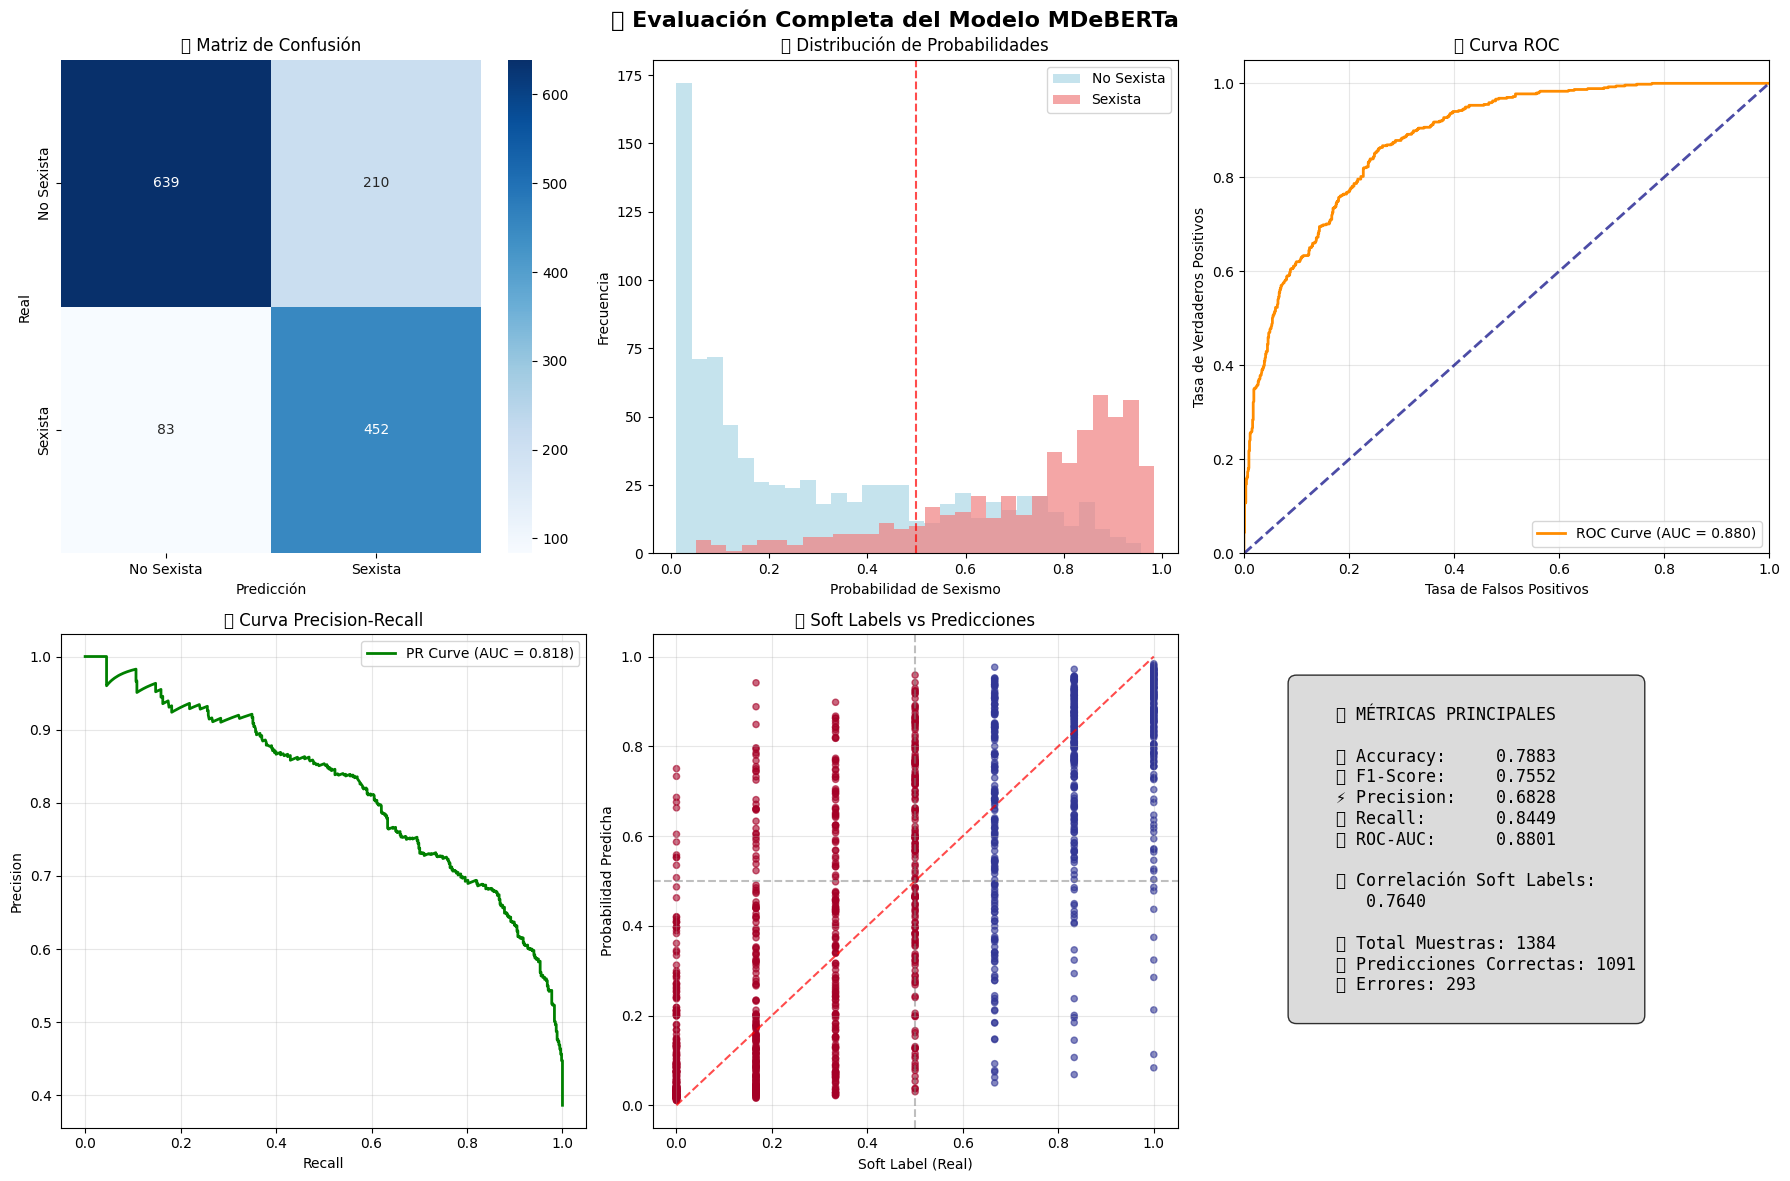

📊 Visualizaciones guardadas en: ./results_hybrid/evaluation_plots.png

📋 ESTADÍSTICAS ADICIONALES:
   📊 Muestras totales evaluadas: 1384
   ✅ Predicciones correctas: 1091
   ❌ Errores totales: 293
   🎯 Confianza promedio: 0.7958

✅ Evaluación completa finalizada exitosamente!


In [95]:
# 📊 VISUALIZACIONES DE LA EVALUACIÓN

print("📊 GENERANDO VISUALIZACIONES DE EVALUACIÓN...")

def create_evaluation_plots(evaluation_df, final_metrics, save_path):
    """Crear visualizaciones completas de la evaluación"""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎯 Evaluación Completa del Modelo MDeBERTa', fontsize=16, fontweight='bold')
    
    # 1. MATRIZ DE CONFUSIÓN
    ax1 = axes[0, 0]
    cm = confusion_matrix(evaluation_df['y_true'], evaluation_df['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Sexista', 'Sexista'],
                yticklabels=['No Sexista', 'Sexista'])
    ax1.set_title('🔢 Matriz de Confusión')
    ax1.set_xlabel('Predicción')
    ax1.set_ylabel('Real')
    
    # 2. DISTRIBUCIÓN DE PROBABILIDADES
    ax2 = axes[0, 1]
    ax2.hist(evaluation_df[evaluation_df['y_true']==0]['y_prob'], 
             alpha=0.7, label='No Sexista', bins=30, color='lightblue')
    ax2.hist(evaluation_df[evaluation_df['y_true']==1]['y_prob'], 
             alpha=0.7, label='Sexista', bins=30, color='lightcoral')
    ax2.set_title('📈 Distribución de Probabilidades')
    ax2.set_xlabel('Probabilidad de Sexismo')
    ax2.set_ylabel('Frecuencia')
    ax2.legend()
    ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
    
    # 3. CURVA ROC
    ax3 = axes[0, 2]
    fpr, tpr, _ = roc_curve(evaluation_df['y_true'], evaluation_df['y_prob'])
    auc_score = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {auc_score:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7)
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Tasa de Falsos Positivos')
    ax3.set_ylabel('Tasa de Verdaderos Positivos')
    ax3.set_title('📊 Curva ROC')
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)
    
    # 4. PRECISION-RECALL CURVE
    ax4 = axes[1, 0]
    precision, recall, _ = precision_recall_curve(evaluation_df['y_true'], evaluation_df['y_prob'])
    pr_auc = auc(recall, precision)
    ax4.plot(recall, precision, color='green', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('🎯 Curva Precision-Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. SOFT LABELS VS PREDICCIONES
    ax5 = axes[1, 1]
    ax5.scatter(evaluation_df['soft_label'], evaluation_df['y_prob'], 
                alpha=0.6, s=20, c=evaluation_df['y_true'], cmap='RdYlBu')
    ax5.plot([0, 1], [0, 1], 'r--', alpha=0.7)
    ax5.set_xlabel('Soft Label (Real)')
    ax5.set_ylabel('Probabilidad Predicha')
    ax5.set_title('🎲 Soft Labels vs Predicciones')
    ax5.grid(True, alpha=0.3)
    
    # Agregar líneas de referencia
    ax5.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax5.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # 6. MÉTRICAS RESUMEN
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Crear texto con métricas principales
    metrics_text = f"""
    🏆 MÉTRICAS PRINCIPALES
    
    📊 Accuracy:     {final_metrics['accuracy']:.4f}
    🎯 F1-Score:     {final_metrics['f1_score']:.4f}
    ⚡ Precision:    {final_metrics['precision']:.4f}
    🔍 Recall:       {final_metrics['recall']:.4f}
    📈 ROC-AUC:      {final_metrics['roc_auc']:.4f}
    
    🎲 Correlación Soft Labels:
       {final_metrics['correlation_soft_labels']:.4f}
    
    📦 Total Muestras: {len(evaluation_df)}
    ✅ Predicciones Correctas: {(evaluation_df['y_true'] == evaluation_df['y_pred']).sum()}
    ❌ Errores: {(evaluation_df['y_true'] != evaluation_df['y_pred']).sum()}
    """
    
    ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, fontsize=12,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualizaciones guardadas en: {save_path}")

# GENERAR VISUALIZACIONES
if 'evaluation_df' in locals() and 'final_metrics' in locals():
    # Crear visualizaciones
    plots_path = f"{manager.paths['output_dir']}/evaluation_plots.png"
    create_evaluation_plots(evaluation_df, final_metrics, plots_path)
    

    
    # Mostrar estadísticas adicionales
    print("\n📋 ESTADÍSTICAS ADICIONALES:")
    print(f"   📊 Muestras totales evaluadas: {len(evaluation_df)}")
    print(f"   ✅ Predicciones correctas: {(evaluation_df['y_true'] == evaluation_df['y_pred']).sum()}")
    print(f"   ❌ Errores totales: {(evaluation_df['y_true'] != evaluation_df['y_pred']).sum()}")
    print(f"   🎯 Confianza promedio: {np.maximum(evaluation_df['y_prob'], 1-evaluation_df['y_prob']).mean():.4f}")
    
    # Análisis de distribución por idioma si está disponible
    if 'lang' in evaluation_df.columns:
        print(f"\n🌍 DISTRIBUCIÓN POR IDIOMA:")
        lang_stats = evaluation_df.groupby('lang').agg({
            'y_true': 'count',
            'y_pred': lambda x: (x == evaluation_df.loc[x.index, 'y_true']).mean()
        }).round(4)
        lang_stats.columns = ['Muestras', 'Accuracy']
        print(lang_stats)
    
    print("\n✅ Evaluación completa finalizada exitosamente!")
    
else:
    print("⚠️  Ejecuta primero la celda de evaluación anterior")

In [96]:
# 🔍 ANÁLISIS DE CASOS ESPECÍFICOS Y RECOMENDACIONES

print("🔍 ANÁLISIS DETALLADO DE CASOS ESPECÍFICOS")
print("="*60)

def analyze_specific_cases(evaluation_df, test_df, n_examples=5):
    """Analizar casos específicos para entender el comportamiento del modelo"""
    
    if len(test_df) != len(evaluation_df):
        print("⚠️  No se puede realizar análisis de casos específicos (datasets no coinciden)")
        return
    
    # Combinar datos para análisis
    analysis_df = evaluation_df.copy()
    analysis_df['text_clean'] = test_df['text_clean'].values
    analysis_df['id_EXIST'] = test_df['id_EXIST'].values
    if 'lang' not in analysis_df.columns:
        analysis_df['lang'] = test_df['lang'].values
    
    print(f"\n✅ Datos combinados para análisis: {len(analysis_df)} muestras")
    
    # 1. CASOS PERFECTAMENTE CLASIFICADOS CON ALTA CONFIANZA
    print(f"\n🎯 1. CASOS PERFECTAMENTE CLASIFICADOS (Alta confianza):")
    perfect_mask = (analysis_df['y_true'] == analysis_df['y_pred']) & \
                   (np.maximum(analysis_df['y_prob'], 1-analysis_df['y_prob']) > 0.9)
    
    if perfect_mask.sum() > 0:
        perfect_cases = analysis_df[perfect_mask].sample(min(n_examples, perfect_mask.sum()), random_state=42)
        print(f"   📊 Total casos perfectos: {perfect_mask.sum()} ({perfect_mask.mean()*100:.1f}%)")
        
        for idx, (_, row) in enumerate(perfect_cases.iterrows()):
            confidence = max(row['y_prob'], 1-row['y_prob'])
            label_text = "SEXISTA" if row['y_true'] else "NO SEXISTA"
            print(f"\n   {idx+1}. [{row['lang'].upper()}] {label_text} (conf: {confidence:.3f})")
            print(f"      '{row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}'")
            print(f"      Soft label: {row['soft_label']:.3f} → Predicción: {row['y_prob']:.3f}")
    
    # 2. ERRORES CON ALTA CONFIANZA (CASOS MÁS PROBLEMÁTICOS)
    print(f"\n❌ 2. ERRORES CON ALTA CONFIANZA (Casos problemáticos):")
    error_mask = (analysis_df['y_true'] != analysis_df['y_pred']) & \
                 (np.maximum(analysis_df['y_prob'], 1-analysis_df['y_prob']) > 0.8)
    
    if error_mask.sum() > 0:
        error_cases = analysis_df[error_mask].sample(min(n_examples, error_mask.sum()), random_state=42)
        print(f"   📊 Total errores alta confianza: {error_mask.sum()} ({error_mask.mean()*100:.1f}%)")
        
        for idx, (_, row) in enumerate(error_cases.iterrows()):
            confidence = max(row['y_prob'], 1-row['y_prob'])
            real_label = "SEXISTA" if row['y_true'] else "NO SEXISTA"
            pred_label = "SEXISTA" if row['y_pred'] else "NO SEXISTA"
            print(f"\n   {idx+1}. [{row['lang'].upper()}] Real: {real_label} vs Pred: {pred_label} (conf: {confidence:.3f})")
            print(f"      '{row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}'")
            print(f"      Soft label: {row['soft_label']:.3f} → Predicción: {row['y_prob']:.3f}")
    
    # 3. CASOS AMBIGUOS (SOFT LABELS CERCA DE 0.5)
    print(f"\n🤔 3. CASOS AMBIGUOS (Soft labels cerca de 0.5):")
    ambiguous_mask = (analysis_df['soft_label'] > 0.3) & (analysis_df['soft_label'] < 0.7)
    
    if ambiguous_mask.sum() > 0:
        ambiguous_cases = analysis_df[ambiguous_mask].sample(min(n_examples, ambiguous_mask.sum()), random_state=42)
        print(f"   📊 Total casos ambiguos: {ambiguous_mask.sum()} ({ambiguous_mask.mean()*100:.1f}%)")
        
        for idx, (_, row) in enumerate(ambiguous_cases.iterrows()):
            confidence = max(row['y_prob'], 1-row['y_prob'])
            correct = "✅" if row['y_true'] == row['y_pred'] else "❌"
            print(f"\n   {idx+1}. [{row['lang'].upper()}] {correct} Ambiguo (soft: {row['soft_label']:.3f})")
            print(f"      '{row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}'")
            print(f"      Predicción: {row['y_prob']:.3f} (conf: {confidence:.3f})")
    
    # 4. COMPARACIÓN ENTRE IDIOMAS
    print(f"\n🌍 4. COMPARACIÓN ENTRE IDIOMAS:")
    for lang in ['es', 'en']:
        lang_data = analysis_df[analysis_df['lang'] == lang]
        if len(lang_data) > 0:
            lang_accuracy = (lang_data['y_true'] == lang_data['y_pred']).mean()
            lang_confidence = np.maximum(lang_data['y_prob'], 1-lang_data['y_prob']).mean()
            lang_correlation = np.corrcoef(lang_data['soft_label'], lang_data['y_prob'])[0,1]
            
            print(f"\n   📊 {lang.upper()}:")
            print(f"      Muestras: {len(lang_data)}")
            print(f"      Accuracy: {lang_accuracy:.4f}")
            print(f"      Confianza promedio: {lang_confidence:.4f}")
            print(f"      Correlación soft labels: {lang_correlation:.4f}")
    
    return analysis_df

def generate_model_recommendations(final_metrics, evaluation_df):
    """Generar recomendaciones basadas en la evaluación"""
    
    print(f"\n💡 RECOMENDACIONES PARA MEJORAR EL MODELO:")
    print("="*50)
    
    # Análisis de F1-Score
    f1_score = final_metrics['f1_score']
    if f1_score > 0.8:
        print("🎉 EXCELENTE: F1-Score > 0.8")
        print("   ✅ El modelo tiene un rendimiento excelente")
    elif f1_score > 0.7:
        print("👍 BUENO: F1-Score > 0.7")
        print("   🔧 Considera ajustar hiperparámetros para mejorar")
    else:
        print("⚠️  NECESITA MEJORA: F1-Score < 0.7")
        print("   🔧 Requiere optimización significativa")
    
    # Análisis de correlación con soft labels
    correlation = final_metrics['correlation_soft_labels']
    if correlation < 0.6:
        print(f"\n📊 CORRELACIÓN BAJA con soft labels ({correlation:.3f})")
        print("   💡 Recomendaciones:")
        print("   - Ajustar la función de pérdida para soft labels")
        print("   - Considerar usar temperatura scaling")
        print("   - Revisar el preprocesamiento de datos")
    
    # Análisis de balance de clases
    accuracy = final_metrics['accuracy']
    f1 = final_metrics['f1_score']
    if abs(accuracy - f1) > 0.1:
        print(f"\n⚖️  DESBALANCE detectado (Accuracy: {accuracy:.3f}, F1: {f1:.3f})")
        print("   💡 Recomendaciones:")
        print("   - Usar class weights en la función de pérdida")
        print("   - Considerar técnicas de oversampling/undersampling")
        print("   - Ajustar el threshold de clasificación")
    
    # Análisis de confianza
    if 'y_prob' in evaluation_df.columns:
        confidence = np.maximum(evaluation_df['y_prob'], 1-evaluation_df['y_prob'])
        low_confidence_pct = (confidence < 0.7).mean()
        
        if low_confidence_pct > 0.3:
            print(f"\n🎯 BAJA CONFIANZA en {low_confidence_pct*100:.1f}% de predicciones")
            print("   💡 Recomendaciones:")
            print("   - Entrenar más épocas")
            print("   - Usar data augmentation")
            print("   - Considerar ensemble methods")
    
    # Recomendaciones generales
    print(f"\n🚀 RECOMENDACIONES GENERALES:")
    print("   1. 📊 Monitorear métricas en conjunto de validación separado")
    print("   2. 🔄 Experimentar con diferentes learning rates")
    print("   3. 🎯 Probar different números de capas congeladas")
    print("   4. 📈 Considerar curriculum learning con soft labels")
    print("   5. 🔍 Analizar errores por categorías semánticas")
    
    print(f"\n✨ PRÓXIMOS PASOS SUGERIDOS:")
    print("   🎯 1. Ajustar threshold de clasificación si es necesario")
    print("   📊 2. Validar en conjunto de test independiente")
    print("   🚀 3. Preparar modelo para deployment en Azure ML")
    print("   📝 4. Documentar hallazgos y métricas finales")

# EJECUTAR ANÁLISIS COMPLETO
if 'evaluation_df' in locals() and 'test_df' in locals() and 'final_metrics' in locals():
    
    # Análisis de casos específicos
    detailed_analysis = analyze_specific_cases(evaluation_df, test_df, n_examples=3)
    
    # Generar recomendaciones
    generate_model_recommendations(final_metrics, evaluation_df)
    
    # Resumen final
    print(f"\n🏆 RESUMEN FINAL DE EVALUACIÓN:")
    print("="*50)
    print(f"📊 Modelo: MDeBERTa-v3-base con Soft Labels")
    print(f"🎯 F1-Score: {final_metrics['f1_score']:.4f}")
    print(f"📈 Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"🔄 ROC-AUC: {final_metrics['roc_auc']:.4f}")
    print(f"🎲 Correlación Soft Labels: {final_metrics['correlation_soft_labels']:.4f}")
    print(f"📦 Muestras evaluadas: {len(evaluation_df)}")
    print(f"✅ Estado: {'LISTO PARA PRODUCCIÓN' if final_metrics['f1_score'] > 0.75 else 'REQUIERE OPTIMIZACIÓN'}")
    
    print(f"\n💾 Todos los resultados guardados en: {manager.paths['output_dir']}")
    
else:
    print("⚠️  Ejecuta primero las celdas de evaluación anteriores")

print("="*60)

🔍 ANÁLISIS DETALLADO DE CASOS ESPECÍFICOS

✅ Datos combinados para análisis: 1384 muestras

🎯 1. CASOS PERFECTAMENTE CLASIFICADOS (Alta confianza):
   📊 Total casos perfectos: 436 (31.5%)

   1. [EN] SEXISTA (conf: 0.943)
      'Fat Men and slim women handshake'
      Soft label: 1.000 → Predicción: 0.943

   2. [EN] SEXISTA (conf: 0.931)
      'You can pinpoint where I stopped caring about my health tonight. It wasn't when I decided country gr...'
      Soft label: 0.833 → Predicción: 0.931

   3. [EN] NO SEXISTA (conf: 0.978)
      '// suggestive ? nsfw ?Choke me like you hate me, but you love meLow-key wanna date me when you fuck ...'
      Soft label: 0.000 → Predicción: 0.022

❌ 2. ERRORES CON ALTA CONFIANZA (Casos problemáticos):
   📊 Total errores alta confianza: 64 (4.6%)

   1. [EN] Real: NO SEXISTA vs Pred: SEXISTA (conf: 0.865)
      '@samuelanjorin__ Haha, this thing, so far it's a woman driving, you find that your anger just assuag...'
      Soft label: 0.500 → Predicción:

📊 BÚSQUEDA DEL MEJOR UMBRAL:
   🎯 Mejor F1-Score: 0.7591
   📈 Umbral óptimo:  0.48
   (Con Precisión: 0.6795 y Recall: 0.8598)


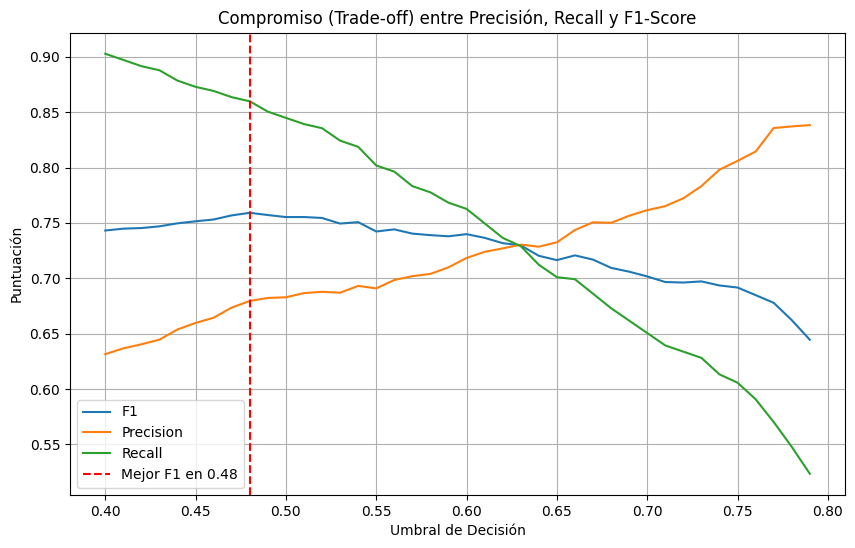

In [ ]:
# Usar el DataFrame de evaluación que ya creaste
y_true = evaluation_df['y_true']
y_prob = evaluation_df['y_prob']

# Probar umbrales desde 0.4 hasta 0.8 en pequeños pasos
thresholds = np.arange(0.4, 0.8, 0.01)
scores = []

for thresh in thresholds:
    preds = (y_prob > thresh).astype(int)
    f1 = f1_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    scores.append([thresh, f1, precision, recall])

# Encontrar el mejor resultado
scores_df = pd.DataFrame(scores, columns=['Threshold', 'F1', 'Precision', 'Recall'])
best_threshold = scores_df.sort_values(by='F1', ascending=False).iloc[0]

print("📊 BÚSQUEDA DEL MEJOR UMBRAL:")
print("="*40)
print(f"   🎯 Mejor F1-Score: {best_threshold['F1']:.4f}")
print(f"   📈 Umbral óptimo:  {best_threshold['Threshold']:.2f}")
print(f"   (Con Precisión: {best_threshold['Precision']:.4f} y Recall: {best_threshold['Recall']:.4f})")
print("="*40)

# Graficar los resultados
scores_df.plot(x='Threshold', y=['F1', 'Precision', 'Recall'], figsize=(10, 6))
plt.title('Compromiso (Trade-off) entre Precisión, Recall y F1-Score')
plt.ylabel('Puntuación')
plt.xlabel('Umbral de Decisión')
plt.grid(True)
plt.axvline(x=best_threshold['Threshold'], color='r', linestyle='--', label=f'Mejor F1 en {best_threshold["Threshold"]:.2f}')
plt.legend()
plt.show()

## Análisis exploratorio y creación de soft labels para Task 1.2
En esta sección se realiza el análisis exploratorio de la distribución de clases por anotador y se genera la variable `soft_task1_2` (distribución de votos por tweet para las clases de intención).

In [3]:
!pip install -U seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ---------------------------------------- 8.1/8.1 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 111.1/111.1 KB 3.3 MB/s eta 0:00:00
     -------------------------------------- 221.2/221.2 KB 2.7 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 73.7/73.7 KB 2.0 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\luisa\OneDrive\Documents\MASTER\IA GENERATIV SISTEMAS ABIERTOS\IAGENOPENSYS\rag-example\venv_py311\Scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
!pwd

"pwd" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


### Análisis de desacuerdo entre anotadores para Task 1.2
A continuación se analiza el nivel de acuerdo/desacuerdo entre los 6 anotadores para cada tweet, visualizando la cantidad de clases distintas por tweet y la proporción de ejemplos con acuerdo total, parcial o máximo desacuerdo.

In [ ]:
# Cargar el dataset (ajusta la ruta a tu archivo CSV)
# Cargar CSV preprocesado desde la ubicación real
#csv_path = f"{manager.paths['data_path']}/subtask1_1_clean_soft_labels.csv"
csv_path = "/home/luisa-fernanda/Descargas/pers/sre/src/data/subtask1_1_full_clean.csv"
df = pd.read_csv(csv_path) # Cambia 'TU_ARCHIVO.csv' por el nombre real
df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task1_1,labels_task1_2,labels_task1_3,split,text_clean,label_soft_task1_1
0,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['White or Caucasian', 'Hispano or Latino', 'W...","['Bachelor’s degree', 'Bachelor’s degree', 'Hi...","['Italy', 'Mexico', 'United States', 'Spain', ...","['YES', 'YES', 'NO', 'YES', 'YES', 'YES']","['REPORTED', 'JUDGEMENTAL', '-', 'REPORTED', '...","[['OBJECTIFICATION'], ['OBJECTIFICATION', 'SEX...",TRAIN_ES,"@TheChiflis Ignora al otro, es un capullo.El p...","[0.16666666666666666, 0.8333333333333334]"
1,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"['Annotator_7', 'Annotator_8', 'Annotator_9', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Black or African American', 'Hispano or Lati...","['High school degree or equivalent', 'Bachelor...","['United Kingdom', 'Mexico', 'United States', ...","['NO', 'NO', 'NO', 'NO', 'YES', 'NO']","['-', '-', '-', '-', 'DIRECT', '-']","[['-'], ['-'], ['-'], ['-'], ['OBJECTIFICATION...",TRAIN_ES,@ultimonomada_ Si comicsgate se parece en algo...,"[0.8333333333333334, 0.16666666666666666]"
2,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"['Annotator_7', 'Annotator_8', 'Annotator_9', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Black or African American', 'Hispano or Lati...","['High school degree or equivalent', 'Bachelor...","['United Kingdom', 'Mexico', 'United States', ...","['NO', 'NO', 'NO', 'NO', 'NO', 'NO']","['-', '-', '-', '-', '-', '-']","[['-'], ['-'], ['-'], ['-'], ['-'], ['-']]",TRAIN_ES,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[1.0, 0.0]"
3,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"['Annotator_13', 'Annotator_14', 'Annotator_15...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Hispano or Latino', 'Hispano or Latino', 'Wh...","['High school degree or equivalent', 'Bachelor...","['Mexico', 'Chile', 'Spain', 'Spain', 'Portuga...","['NO', 'NO', 'YES', 'NO', 'YES', 'YES']","['-', '-', 'DIRECT', '-', 'REPORTED', 'REPORTED']","[['-'], ['-'], ['IDEOLOGICAL-INEQUALITY'], ['-...",TRAIN_ES,@Lunariita7 Un retraso social bastante lamenta...,"[0.5, 0.5]"
4,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"['Annotator_19', 'Annotator_20', 'Annotator_21...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Hispano or Latino', 'Hispano or Latino', 'Wh...","['Bachelor’s degree', 'Bachelor’s degree', 'Ma...","['Mexico', 'Afghanistan', 'United States', 'It...","['YES', 'NO', 'YES', 'NO', 'YES', 'YES']","['REPORTED', '-', 'JUDGEMENTAL', '-', 'JUDGEME...","[['STEREOTYPING-DOMINANCE', 'OBJECTIFICATION']...",TRAIN_ES,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[0.3333333333333333, 0.6666666666666666]"


In [ ]:
# Convierte las anotaciones de string a lista
df['labels_task1_2'] = df['labels_task1_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def clean_labels_no_unknown(labels):
    # Reemplaza '-' por 'NO', elimina 'unknown'
    return [l if l != '-' else 'NO' for l in labels if l not in ['unknown', 'UNKNOWN']]

df['labels_task1_2_clean'] = df['labels_task1_2'].apply(clean_labels_no_unknown)
df = df[df['labels_task1_2_clean'].apply(len) > 0].reset_index(drop=True)

all_labels_flat = [l for labels in df['labels_task1_2_clean'] for l in labels]
all_possible_labels = sorted(set(all_labels_flat))

def get_soft_label(labels):
    count = Counter(labels)
    total = len(labels)
    return [count.get(l,0)/total for l in all_possible_labels]

df['soft_task1_2'] = df['labels_task1_2_clean'].apply(get_soft_label)

print('Clases válidas para soft_task1_2:', all_possible_labels)
print(df[['labels_task1_2','labels_task1_2_clean','soft_task1_2']].head())

Clases válidas para soft_task1_2: ['DIRECT', 'JUDGEMENTAL', 'NO', 'REPORTED']
                                      labels_task1_2  \
0  [REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...   
1                            [-, -, -, -, DIRECT, -]   
2                                 [-, -, -, -, -, -]   
3              [-, -, DIRECT, -, REPORTED, REPORTED]   
4  [REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...   

                                labels_task1_2_clean  \
0  [REPORTED, JUDGEMENTAL, NO, REPORTED, JUDGEMEN...   
1                       [NO, NO, NO, NO, DIRECT, NO]   
2                           [NO, NO, NO, NO, NO, NO]   
3           [NO, NO, DIRECT, NO, REPORTED, REPORTED]   
4  [REPORTED, NO, JUDGEMENTAL, NO, JUDGEMENTAL, D...   

                                        soft_task1_2  
0  [0.0, 0.3333333333333333, 0.16666666666666666,...  
1  [0.16666666666666666, 0.0, 0.8333333333333334,...  
2                               [0.0, 0.0, 1.0, 0.0]  
3  [0.16666666666666666, 0.0

## EDA actualizado tras la normalización de etiquetas y soft labels
A continuación se presentan los análisis exploratorios principales usando las etiquetas y soft labels ya normalizadas para Task 1.2.

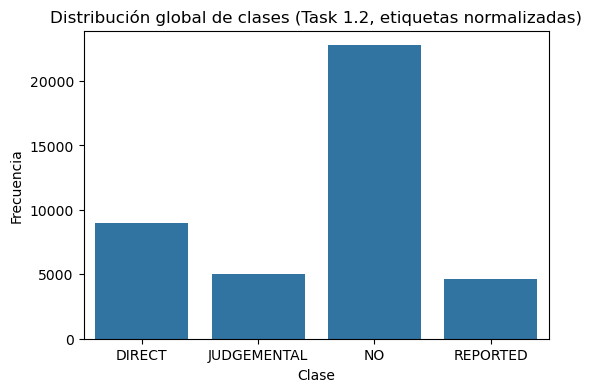

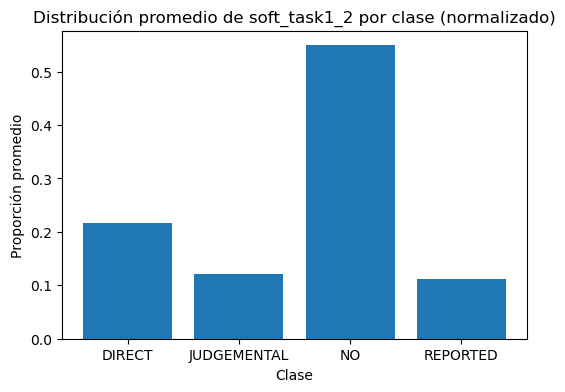

Proporción promedio de soft_task1_2 por clase: [0.21735308 0.12109104 0.54922688 0.112329  ]


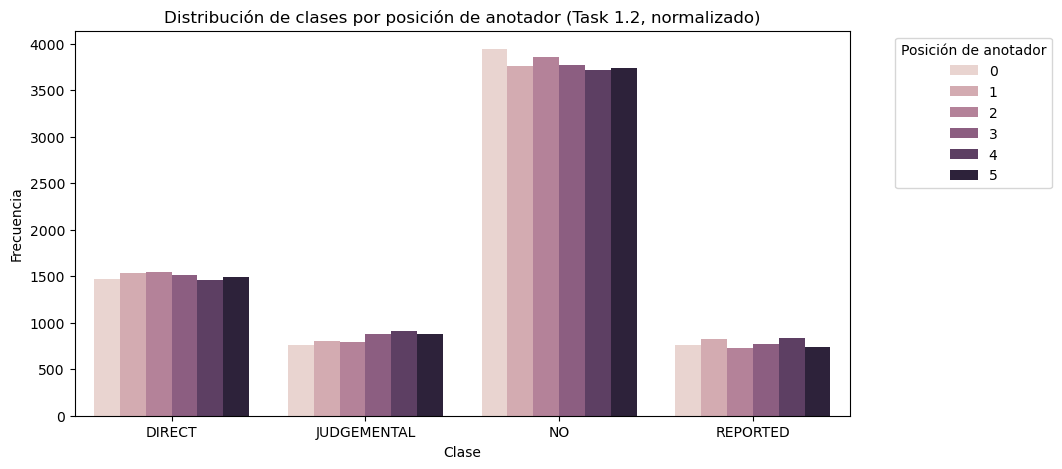

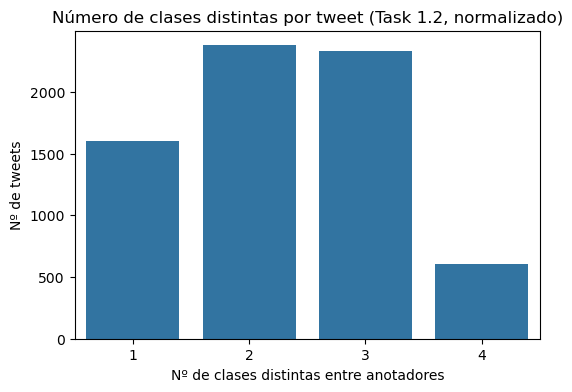

Proporción de tweets con acuerdo total: 23.19%
Proporción de tweets con acuerdo parcial (2 clases): 34.36%
Proporción de tweets con máximo desacuerdo (4 clases): 8.79%


In [ ]:
# 1. Distribución global de clases (todas las anotaciones válidas)
all_labels = [label for labels in df['labels_task1_2_clean'] for label in labels]
plt.figure(figsize=(6,4))
sns.countplot(x=all_labels, order=sorted(set(all_labels)))
plt.title('Distribución global de clases (Task 1.2, etiquetas normalizadas)')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

# 2. Distribución promedio de soft_task1_2 por clase
data_soft = np.vstack(df['soft_task1_2'].values)
mean_soft = data_soft.mean(axis=0)
plt.figure(figsize=(6,4))
plt.bar(range(len(mean_soft)), mean_soft, tick_label=sorted(set(all_labels)))
plt.title('Distribución promedio de soft_task1_2 por clase (normalizado)')
plt.xlabel('Clase')
plt.ylabel('Proporción promedio')
plt.show()
print('Proporción promedio de soft_task1_2 por clase:', mean_soft)

# 3. Distribución de clases por posición de anotador
position_labels = []
for _, row in df.iterrows():
    for pos, label in enumerate(row['labels_task1_2_clean']):
        position_labels.append({'position': pos, 'label': label})
position_df = pd.DataFrame(position_labels)
plt.figure(figsize=(10,5))
sns.countplot(data=position_df, x='label', hue='position', order=sorted(set(all_labels)))
plt.title('Distribución de clases por posición de anotador (Task 1.2, normalizado)')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.legend(title='Posición de anotador', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 4. Desacuerdo entre anotadores (número de clases distintas por tweet)
num_classes_per_tweet = df['labels_task1_2_clean'].apply(lambda x: len(set(x)))
plt.figure(figsize=(6,4))
sns.countplot(x=num_classes_per_tweet)
plt.title('Número de clases distintas por tweet (Task 1.2, normalizado)')
plt.xlabel('Nº de clases distintas entre anotadores')
plt.ylabel('Nº de tweets')
plt.show()

acuerdo_total = (num_classes_per_tweet == 1).mean()
acuerdo_parcial = (num_classes_per_tweet == 2).mean()
desacuerdo_max = (num_classes_per_tweet == len(mean_soft)).mean()
print(f"Proporción de tweets con acuerdo total: {acuerdo_total:.2%}")
print(f"Proporción de tweets con acuerdo parcial (2 clases): {acuerdo_parcial:.2%}")
print(f"Proporción de tweets con máximo desacuerdo ({len(mean_soft)} clases): {desacuerdo_max:.2%}")

In [9]:
df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task1_1,labels_task1_2,labels_task1_3,split,text_clean,label_soft_task1_1,labels_task1_2_clean,soft_task1_2
0,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['White or Caucasian', 'Hispano or Latino', 'W...","['Bachelor’s degree', 'Bachelor’s degree', 'Hi...","['Italy', 'Mexico', 'United States', 'Spain', ...","['YES', 'YES', 'NO', 'YES', 'YES', 'YES']","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[['OBJECTIFICATION'], ['OBJECTIFICATION', 'SEX...",TRAIN_ES,"@TheChiflis Ignora al otro, es un capullo.El p...","[0.16666666666666666, 0.8333333333333334]","[REPORTED, JUDGEMENTAL, NO, REPORTED, JUDGEMEN...","[0.0, 0.3333333333333333, 0.16666666666666666,..."
1,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"['Annotator_7', 'Annotator_8', 'Annotator_9', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Black or African American', 'Hispano or Lati...","['High school degree or equivalent', 'Bachelor...","['United Kingdom', 'Mexico', 'United States', ...","['NO', 'NO', 'NO', 'NO', 'YES', 'NO']","[-, -, -, -, DIRECT, -]","[['-'], ['-'], ['-'], ['-'], ['OBJECTIFICATION...",TRAIN_ES,@ultimonomada_ Si comicsgate se parece en algo...,"[0.8333333333333334, 0.16666666666666666]","[NO, NO, NO, NO, DIRECT, NO]","[0.16666666666666666, 0.0, 0.8333333333333334,..."
2,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"['Annotator_7', 'Annotator_8', 'Annotator_9', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Black or African American', 'Hispano or Lati...","['High school degree or equivalent', 'Bachelor...","['United Kingdom', 'Mexico', 'United States', ...","['NO', 'NO', 'NO', 'NO', 'NO', 'NO']","[-, -, -, -, -, -]","[['-'], ['-'], ['-'], ['-'], ['-'], ['-']]",TRAIN_ES,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[1.0, 0.0]","[NO, NO, NO, NO, NO, NO]","[0.0, 0.0, 1.0, 0.0]"
3,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"['Annotator_13', 'Annotator_14', 'Annotator_15...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Hispano or Latino', 'Hispano or Latino', 'Wh...","['High school degree or equivalent', 'Bachelor...","['Mexico', 'Chile', 'Spain', 'Spain', 'Portuga...","['NO', 'NO', 'YES', 'NO', 'YES', 'YES']","[-, -, DIRECT, -, REPORTED, REPORTED]","[['-'], ['-'], ['IDEOLOGICAL-INEQUALITY'], ['-...",TRAIN_ES,@Lunariita7 Un retraso social bastante lamenta...,"[0.5, 0.5]","[NO, NO, DIRECT, NO, REPORTED, REPORTED]","[0.16666666666666666, 0.0, 0.5, 0.333333333333..."
4,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"['Annotator_19', 'Annotator_20', 'Annotator_21...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Hispano or Latino', 'Hispano or Latino', 'Wh...","['Bachelor’s degree', 'Bachelor’s degree', 'Ma...","['Mexico', 'Afghanistan', 'United States', 'It...","['YES', 'NO', 'YES', 'NO', 'YES', 'YES']","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[['STEREOTYPING-DOMINANCE', 'OBJECTIFICATION']...",TRAIN_ES,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[0.3333333333333333, 0.6666666666666666]","[REPORTED, NO, JUDGEMENTAL, NO, JUDGEMENTAL, D...","[0.16666666666666666, 0.3333333333333333, 0.33..."


In [10]:
# Guardar el DataFrame completo (con columnas limpias y soft labels)
df.to_csv('dataset_task1_2_limpio.csv', index=False)
print('DataFrame guardado como dataset_task1_2_limpio.csv')

DataFrame guardado como dataset_task1_2_limpio.csv


In [30]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 5.5 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 9.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 9.8 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 12.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 13.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 13.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Entrenamiento de un modelo Transformer para Task 1.2
A continuación se muestra cómo entrenar un modelo transformer multilingüe (ejemplo: xlm-roberta-base) usando los datos normalizados y las etiquetas de Task 1.2.

In [ ]:

# Detectar si hay una GPU disponible (CUDA) y seleccionarla, de lo contrario, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"🔥 Nombre de la GPU: {torch.cuda.get_device_name(0)}")

✅ Dispositivo seleccionado: cuda
🔥 Nombre de la GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [12]:
csv_path = "/home/luisa-fernanda/Descargas/pers/sre/src/data/dataset_task1_2_limpio.csv"
df = pd.read_csv(csv_path) # Cambia 'TU_ARCHIVO.csv' por el nombre real
df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task1_1,labels_task1_2,labels_task1_3,split,text_clean,label_soft_task1_1,labels_task1_2_clean,soft_task1_2
0,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['White or Caucasian', 'Hispano or Latino', 'W...","['Bachelor’s degree', 'Bachelor’s degree', 'Hi...","['Italy', 'Mexico', 'United States', 'Spain', ...","['YES', 'YES', 'NO', 'YES', 'YES', 'YES']","['REPORTED', 'JUDGEMENTAL', '-', 'REPORTED', '...","[['OBJECTIFICATION'], ['OBJECTIFICATION', 'SEX...",TRAIN_ES,"@TheChiflis Ignora al otro, es un capullo.El p...","[0.16666666666666666, 0.8333333333333334]","['REPORTED', 'JUDGEMENTAL', 'NO', 'REPORTED', ...","[0.0, 0.3333333333333333, 0.16666666666666666,..."
1,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"['Annotator_7', 'Annotator_8', 'Annotator_9', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Black or African American', 'Hispano or Lati...","['High school degree or equivalent', 'Bachelor...","['United Kingdom', 'Mexico', 'United States', ...","['NO', 'NO', 'NO', 'NO', 'YES', 'NO']","['-', '-', '-', '-', 'DIRECT', '-']","[['-'], ['-'], ['-'], ['-'], ['OBJECTIFICATION...",TRAIN_ES,@ultimonomada_ Si comicsgate se parece en algo...,"[0.8333333333333334, 0.16666666666666666]","['NO', 'NO', 'NO', 'NO', 'DIRECT', 'NO']","[0.16666666666666666, 0.0, 0.8333333333333334,..."
2,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"['Annotator_7', 'Annotator_8', 'Annotator_9', ...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Black or African American', 'Hispano or Lati...","['High school degree or equivalent', 'Bachelor...","['United Kingdom', 'Mexico', 'United States', ...","['NO', 'NO', 'NO', 'NO', 'NO', 'NO']","['-', '-', '-', '-', '-', '-']","[['-'], ['-'], ['-'], ['-'], ['-'], ['-']]",TRAIN_ES,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[1.0, 0.0]","['NO', 'NO', 'NO', 'NO', 'NO', 'NO']","[0.0, 0.0, 1.0, 0.0]"
3,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"['Annotator_13', 'Annotator_14', 'Annotator_15...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Hispano or Latino', 'Hispano or Latino', 'Wh...","['High school degree or equivalent', 'Bachelor...","['Mexico', 'Chile', 'Spain', 'Spain', 'Portuga...","['NO', 'NO', 'YES', 'NO', 'YES', 'YES']","['-', '-', 'DIRECT', '-', 'REPORTED', 'REPORTED']","[['-'], ['-'], ['IDEOLOGICAL-INEQUALITY'], ['-...",TRAIN_ES,@Lunariita7 Un retraso social bastante lamenta...,"[0.5, 0.5]","['NO', 'NO', 'DIRECT', 'NO', 'REPORTED', 'REPO...","[0.16666666666666666, 0.0, 0.5, 0.333333333333..."
4,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"['Annotator_19', 'Annotator_20', 'Annotator_21...","['F', 'F', 'F', 'M', 'M', 'M']","['18-22', '23-45', '46+', '46+', '23-45', '18-...","['Hispano or Latino', 'Hispano or Latino', 'Wh...","['Bachelor’s degree', 'Bachelor’s degree', 'Ma...","['Mexico', 'Afghanistan', 'United States', 'It...","['YES', 'NO', 'YES', 'NO', 'YES', 'YES']","['REPORTED', '-', 'JUDGEMENTAL', '-', 'JUDGEME...","[['STEREOTYPING-DOMINANCE', 'OBJECTIFICATION']...",TRAIN_ES,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[0.3333333333333333, 0.6666666666666666]","['REPORTED', 'NO', 'JUDGEMENTAL', 'NO', 'JUDGE...","[0.16666666666666666, 0.3333333333333333, 0.33..."


In [ ]:
# 1. Cargar datos y preparar clases
csv_path = "/home/luisa-fernanda/Descargas/pers/sre/src/data/dataset_task1_2_limpio.csv"
df = pd.read_csv(csv_path)

# Definir todas las clases posibles
all_labels_flat = [l for labels in df['labels_task1_2_clean'] for l in eval(labels) if isinstance(labels, str) or isinstance(labels, list)]
all_possible_labels = sorted(set(all_labels_flat))
label2id = {label: idx for idx, label in enumerate(all_possible_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Crear columna de clase principal (solo una clase por tweet)
df['class'] = df['labels_task1_2_clean'].apply(lambda x: label2id[eval(x)[0]] if isinstance(x, str) else label2id[x[0]])

# Filtrar solo columnas necesarias para el modelo
df_model = df[['text_clean', 'class']].rename(columns={'text_clean': 'text', 'class': 'label'})
dataset = Dataset.from_pandas(df_model)



In [19]:
df_model.head()

,text,label
0,"@TheChiflis Ignora al otro, es un capullo.El p...",3
1,@ultimonomada_ Si comicsgate se parece en algo...,2
2,"@Steven2897 Lee sobre Gamergate, y como eso ha...",2
3,@Lunariita7 Un retraso social bastante lamenta...,2
4,@novadragon21 @icep4ck @TvDannyZ Entonces como...,3


In [ ]:
# ...existing code...

# 3. Tokenizador y preprocesamiento
MODEL_NAME = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Definir diccionarios de clases
label2id = {label: idx for idx, label in enumerate(all_possible_labels)}
id2label = {idx: label for label, idx in label2id.items()}

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

# 4. Split train/test
dataset_split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

# 5. Modelo multicategoría con congelamiento
labels = [label for label in df_model['label']]
print(f"Clases en el dataset: {set(labels)}")
class_counts = np.bincount(labels)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


# Usar id2label y label2id en la configuración
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

class CustomMultiClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=None, layers_to_freeze=4, dropout=0.3, class_weights=None, config=None):
        super().__init__()
        self.config = config if config is not None else AutoConfig.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)
        for name, param in self.encoder.named_parameters():
            should_freeze = False
            if 'embeddings' in name:
                should_freeze = True
            elif 'encoder.layer.' in name:
                try:
                    layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                    if layer_num < layers_to_freeze:
                        should_freeze = True
                except Exception:
                    pass
            param.requires_grad = not should_freeze
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        self.class_weights = class_weights
        self.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    def forward(self, input_ids, attention_mask=None, labels=None):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(output.last_hidden_state[:, 0])
        logits = self.classifier(pooled)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fn(logits, labels.long())
        return {"loss": loss, "logits": logits}

# 6. Inicializar modelo con config que incluye nombres de clase
model = CustomMultiClassifier(
    model_name=MODEL_NAME,
    num_labels=len(label2id),
    layers_to_freeze=4,
    dropout=0.3,
    class_weights=class_weights_tensor,
    config=config
)



# 7. Métrica
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

print(f"⚙️ CONFIGURACIÓN DE ENTRENAMIENTO :")
print(f"   📦 Batch size: {training_config['batch_size']}")
print(f"   🔄 Épocas: {training_config['num_epochs']}")
print(f"   📈 Learning rate: {training_config['learning_rate']}")
print(f"   🔢 Accumulation steps: {training_config['gradient_accumulation_steps']}")
print(f"   � Workers: {training_config['dataloader_num_workers']}")

# 8. Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results_task1_2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=training_config['learning_rate'],
    per_device_train_batch_size=training_config['batch_size'],
    per_device_eval_batch_size=training_config['batch_size'],
    gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
    num_train_epochs=5,
    warmup_steps=150,
    weight_decay=0.01,
    logging_dir=manager.paths['output_dir'] + '/logs',
    logging_steps=100,
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=training_config['dataloader_num_workers'],
    save_total_limit=2,
    remove_unused_columns=False,
    report_to=None,
    log_level='error',
    disable_tqdm=False,
    skip_memory_metrics=True,
    dataloader_drop_last=False,
    prediction_loss_only=False
)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 10. Entrenamiento
print("🚀 Iniciando entrenamiento Task 1.2 ...")
trainer.train()



Map: 100%|██████████| 6920/6920 [00:00<00:00, 14751.94 examples/s]


Clases en el dataset: {0, 1, 2, 3}


/home/luisa-fernanda/.conda/envs/tfmy_env/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


🚀 Iniciando entrenamiento Task 1.2 ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1
1,1.465800,1.327327,0.301305
2,1.418800,1.326239,0.265961
3,1.272400,1.237429,0.410700
4,1.050200,1.164938,0.485916


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=970, training_loss=1.259556839146565, metrics={'train_runtime': 460.063, 'train_samples_per_second': 67.686, 'train_steps_per_second': 2.108, 'total_flos': 0.0, 'train_loss': 1.259556839146565, 'epoch': 4.975609756097561})

In [ ]:
# 11. Guardar modelo y tokenizer
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
custom_model_name = f"xlm-roberta-task1_2-{timestamp}"
trainer.save_model(f"{manager.paths['model_save_path']}/{custom_model_name}")
tokenizer.save_pretrained(f"./{custom_model_name}")
#print(f"Entrenamiento finalizado y modelo guardado en ./{custom_model_name}")

🔮 Generando predicciones en el conjunto de test...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

📊 Reporte de clasificación (macro):
              precision    recall  f1-score   support

      DIRECT       0.44      0.59      0.51       135
 JUDGEMENTAL       0.25      0.27      0.26        75
          NO       0.85      0.68      0.76       403
    REPORTED       0.36      0.49      0.42        79

    accuracy                           0.60       692
   macro avg       0.48      0.51      0.49       692
weighted avg       0.65      0.60      0.62       692



/home/luisa-fernanda/.conda/envs/tfmy_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_72724/3813673977.py:49: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_72724/3813673977.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_72724/3813673977.py:50: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_72724/3813673977.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_72724/3813673977.py:50: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path

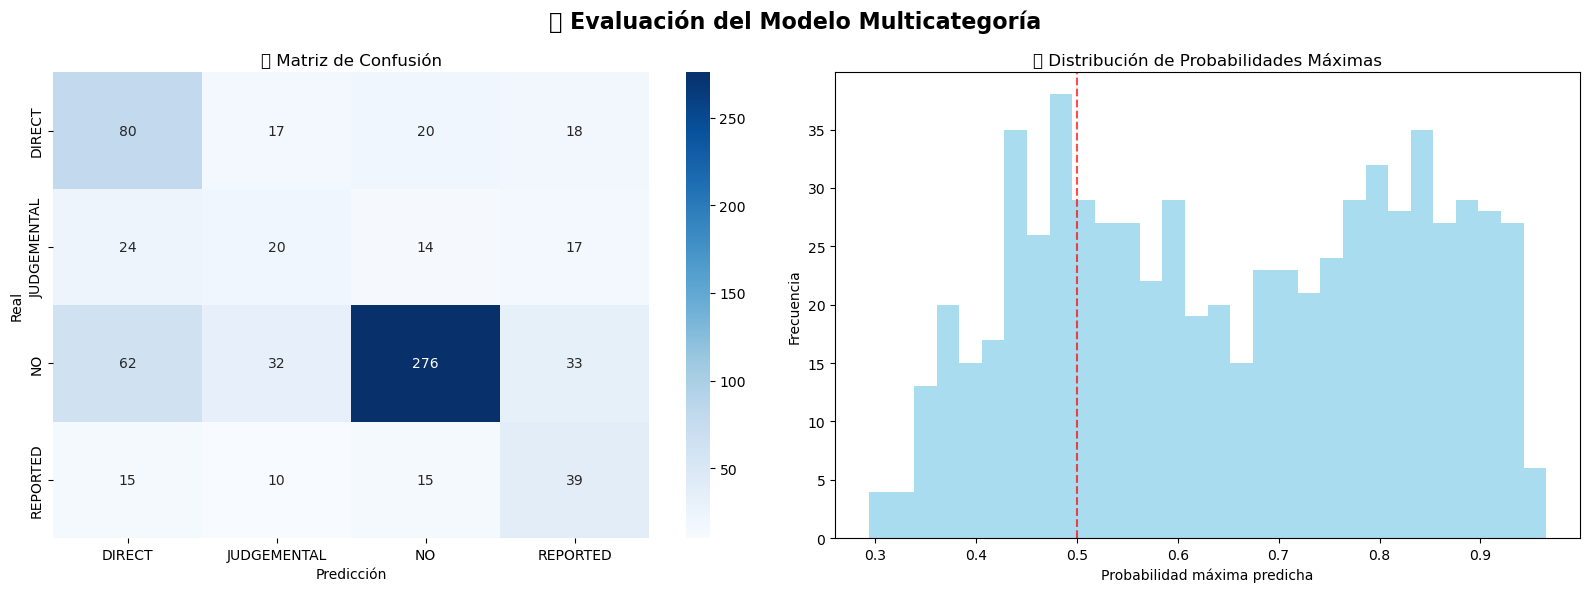

📊 Visualizaciones guardadas en: ./results_task1_2/evaluation_plots_multiclass.png

📋 ESTADÍSTICAS ADICIONALES:
   📊 Muestras totales evaluadas: 692
   ✅ Predicciones correctas: 415
   ❌ Errores totales: 277
   🎯 Confianza promedio: 0.6545

Ejemplo de predicción:
Texto: @Brezia_Tomson @missy_steak Women have todo still live with them… only men can understand their humor rolling on the floor laughinggrinning face with big eyes
Real: DIRECT
Predicho: DIRECT


In [ ]:

# Realizar predicciones en el conjunto de test
print("🔮 Generando predicciones en el conjunto de test...")
predictions = trainer.predict(dataset_split["test"])
logits = predictions.predictions
labels_true = predictions.label_ids
labels_pred = np.argmax(logits, axis=-1)

# Crear DataFrame de evaluación para visualizaciones
evaluation_df = pd.DataFrame({
    'y_true': labels_true,
    'y_pred': labels_pred,
    # Para modelos multicategoría, puedes usar softmax para probabilidades
    'y_prob': np.max(np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True), axis=1)
})

# Reporte de métricas
print("📊 Reporte de clasificación (macro):")
print(classification_report(labels_true, labels_pred, target_names=[id2label[i] for i in sorted(id2label)]))

# Visualizaciones
def create_evaluation_plots_multiclass(evaluation_df, labels_true, labels_pred, id2label, save_path):
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('🎯 Evaluación del Modelo Multicategoría', fontsize=16, fontweight='bold')

    # 1. Matriz de confusión
    ax1 = axes[0]
    cm = confusion_matrix(labels_true, labels_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=[id2label[i] for i in sorted(id2label)],
                yticklabels=[id2label[i] for i in sorted(id2label)])
    ax1.set_title('🔢 Matriz de Confusión')
    ax1.set_xlabel('Predicción')
    ax1.set_ylabel('Real')

    # 2. Distribución de probabilidades predichas (solo para la clase predicha)
    ax2 = axes[1]
    ax2.hist(evaluation_df['y_prob'], bins=30, color='skyblue', alpha=0.7)
    ax2.set_title('📈 Distribución de Probabilidades Máximas')
    ax2.set_xlabel('Probabilidad máxima predicha')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Visualizaciones guardadas en: {save_path}")

# Guardar y mostrar visualizaciones
plots_path = "./results_task1_2/evaluation_plots_multiclass.png"
create_evaluation_plots_multiclass(evaluation_df, labels_true, labels_pred, id2label, plots_path)

# Estadísticas adicionales
print("\n📋 ESTADÍSTICAS ADICIONALES:")
print(f"   📊 Muestras totales evaluadas: {len(evaluation_df)}")
print(f"   ✅ Predicciones correctas: {(evaluation_df['y_true'] == evaluation_df['y_pred']).sum()}")
print(f"   ❌ Errores totales: {(evaluation_df['y_true'] != evaluation_df['y_pred']).sum()}")
print(f"   🎯 Confianza promedio: {evaluation_df['y_prob'].mean():.4f}")

# Ejemplo de predicción individual
idx = 0  # Cambia el índice para ver otros ejemplos
print("\nEjemplo de predicción:")
print("Texto:", dataset_split["test"][idx]["text"])
print("Real:", id2label[labels_true[idx]])
print("Predicho:", id2label[labels_pred[idx]])

In [1]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from safetensors.torch import load_file
import os

# --- Definición del modelo ---
class SoftMultiClassifier(nn.Module):
    MODEL_NAME = "xlm-roberta-large"
    def __init__(self, model_name: str = MODEL_NAME, num_labels: int = 4, dropout: float = 0.3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        self.to(device)
        self.device = device

    def forward(self, input_ids, attention_mask=None, **kwargs):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(output.last_hidden_state[:, 0])
        logits = self.classifier(pooled)
        return SequenceClassifierOutput(loss=None, logits=logits)

# --- Carga del modelo y tokenizer ---
model_path = "/home/luisa-fernanda/Descargas/pers/sre/src/models/model_1_2_xml_roberta"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_tokenizer_1_2 = AutoTokenizer.from_pretrained(model_path)
transformer_model_1_2 = SoftMultiClassifier()
weights_path = os.path.join(model_path, 'model.safetensors')
state_dict = load_file(weights_path, device=str(device))
transformer_model_1_2.load_state_dict(state_dict)
transformer_model_1_2.to(device)
transformer_model_1_2.eval()
print("   ✅ Modelo 1.2 cargado y listo.")

idx2label = {0: "DIRECT", 1: "REPORTED", 2: "JUDGEMENTAL", 3: "NO"}

def predict_intention(text):
    inputs = transformer_tokenizer_1_2(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = transformer_model_1_2(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    pred_idx = int(np.argmax(probs))
    return {
        'label': idx2label[pred_idx],
        'prob': float(np.max(probs)),
        'probs': probs
    }

# --- Ejemplo de uso ---
test_text = "Este es un ejemplo de tweet para clasificar."
result = predict_intention(test_text)
print(f"Texto: {test_text}")
print(f"Predicción: {result['label']} (prob: {result['prob']:.3f})")
print(f"Probabilidades por clase: {dict(zip(idx2label.values(), result['probs']))}")

/home/luisa-fernanda/.conda/envs/tfmy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   ✅ Modelo 1.2 cargado y listo.
Texto: Este es un ejemplo de tweet para clasificar.
Predicción: JUDGEMENTAL (prob: 0.870)
Probabilidades por clase: {'DIRECT': 0.039282903, 'REPORTED': 0.07125359, 'JUDGEMENTAL': 0.87029135, 'NO': 0.019172091}


In [ ]:
import json
import pandas as pd

# 1. Cargar el archivo de desarrollo
with open("../data/goldDEV/EXIST2025_dev.json", "r", encoding="utf-8") as f:
    dev_data = json.load(f)
print(f"📚 Datos de desarrollo cargados: {len(dev_data)} ejemplos")

# 2. Extraer los campos requeridos
dev_samples = []
for k, v in dev_data.items():
    if 'tweet' in v:

        dev_samples.append({
            'id_EXIST': v['id_EXIST'],
            'lang': v['lang'],
            'tweet': v['tweet']
        })
df_pred = pd.DataFrame(dev_samples)
print(df_pred.head())

# 3. Realizar predicciones y guardar las originales
intention_predictions = []
for idx, row in df_pred.iterrows():
    tweet = row["tweet"]
    result = predict_intention(tweet)
    intention_pred = result['label']
    intention_predictions.append(intention_pred)
   
df_pred['intention_prediction'] = intention_predictions
print(df_pred.head())

# Guardar las predicciones en un CSV
predictions_csv_path = "./predictions_task1_2.csv"
df_pred.to_csv(predictions_csv_path, index=False)
print(f"✅ Predicciones guardadas en CSV: {predictions_csv_path}")

# --- 4. Generar el JSON con la estructura requerida ---
task1_2_json = [
    {
        "test_case": "EXIST2025",
        "id": row["id_EXIST"],
        "value": row["intention_prediction"]
    }
    for _, row in df_pred.iterrows()
]

# Guardar las predicciones en formato JSON para Task 1.2
task1_2_json_path = "./predictions_task1_2.json"
with open(task1_2_json_path, "w", encoding="utf-8") as json_file:
    json.dump(task1_2_json, json_file, ensure_ascii=False, indent=4)

print(f"✅ Predicciones guardadas en formato JSON en: {task1_2_json_path}")

📚 Datos de desarrollo cargados: 1038 ejemplos
  id_EXIST lang                                              tweet
0   300001   es  @Fichinescu La comunidad gamer es un antro de ...
1   300002   es  @anacaotica88 @MordorLivin No me acuerdo de lo...
2   300003   es  @cosmicJunkBot lo digo cada pocos dias y lo re...
3   300004   es  Also mientras les decia eso la señalaba y deci...
4   300005   es  And all people killed,  attacked, harassed by ...
  id_EXIST lang                                              tweet  \
0   300001   es  @Fichinescu La comunidad gamer es un antro de ...   
1   300002   es  @anacaotica88 @MordorLivin No me acuerdo de lo...   
2   300003   es  @cosmicJunkBot lo digo cada pocos dias y lo re...   
3   300004   es  Also mientras les decia eso la señalaba y deci...   
4   300005   es  And all people killed,  attacked, harassed by ...   

  intention_prediction  
0             REPORTED  
1                   NO  
2          JUDGEMENTAL  
3                   NO  
4     

In [14]:
# --- Carga del modelo y tokenizer ---
model_path = "/home/luisa-fernanda/Descargas/pers/sre/src/models/model_1_1_xml_roberta"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_tokenizer_1_1 = AutoTokenizer.from_pretrained(model_path)
transformer_model_1_1 = SoftBinaryClassifier()
weights_path = os.path.join(model_path, 'model.safetensors')
state_dict = load_file(weights_path, device=str(device))
transformer_model_1_1.load_state_dict(state_dict)
transformer_model_1_1.to(device)
transformer_model_1_1.eval()
print("   ✅ Modelo 1.1 cargado y listo.")

🧊 Capas congeladas: embeddings + encoder layers 0-3
📊 Parámetros congelados: 306,916,352 (54.8%)
🎯 Parámetros entrenables: 252,975,105 (45.2%)
   ✅ Modelo 1.1 cargado y listo.


In [21]:
import json
import pandas as pd

# 1. Cargar el archivo de desarrollo
with open("../data/goldDEV/EXIST2025_dev.json", "r", encoding="utf-8") as f:
    dev_data = json.load(f)
print(f"📚 Datos de desarrollo cargados: {len(dev_data)} ejemplos")

# 2. Extraer los campos requeridos
dev_samples = []
for k, v in dev_data.items():
    if 'tweet' in v:

        dev_samples.append({
            'id_EXIST': v['id_EXIST'],
            'lang': v['lang'],
            'tweet': v['tweet']
        })
df_predT = pd.DataFrame(dev_samples)
print(df_predT.head())

# 3. Realizar predicciones y guardar las originales
def predict_binary(text, tokenizer, model, device, threshold=0.5):
    """
    Predice si un texto es sexista (YES/NO) usando un modelo binario transformer.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prob = torch.sigmoid(outputs.logits).cpu().numpy()[0]
    label = "YES" if prob > threshold else "NO"
    return {"label": label, "prob": float(prob)}


binary_predictions = []
binary_probs = []
for idx, row in df_predT.iterrows():
    tweet = row["tweet"]
    result = predict_binary(tweet, transformer_tokenizer_1_1, transformer_model_1_1, device)
    binary_predictions.append(result["label"])
    binary_probs.append(result["prob"])

df_predT["binary_prediction"] = binary_predictions
df_predT["binary_prob"] = binary_probs
print(df_predT.head())


# --- 4. Generar el JSON con la estructura requerida ---
task1_1_json = [
    {
        "test_case": "EXIST2025_1_1",
        "id": row["id_EXIST"],
        "value": row["binary_prediction"]
    }
    for _, row in df_predT.iterrows()
]

# Guardar las predicciones en formato JSON para Task 1.2
task1_1_json_path = "./predictions_task1_1.json"
with open(task1_1_json_path, "w", encoding="utf-8") as json_file:
    json.dump(task1_1_json, json_file, ensure_ascii=False, indent=4)

print(f"✅ Predicciones guardadas en formato JSON en: {task1_1_json_path}")

📚 Datos de desarrollo cargados: 1038 ejemplos
  id_EXIST lang                                              tweet
0   300001   es  @Fichinescu La comunidad gamer es un antro de ...
1   300002   es  @anacaotica88 @MordorLivin No me acuerdo de lo...
2   300003   es  @cosmicJunkBot lo digo cada pocos dias y lo re...
3   300004   es  Also mientras les decia eso la señalaba y deci...
4   300005   es  And all people killed,  attacked, harassed by ...
  id_EXIST lang                                              tweet  \
0   300001   es  @Fichinescu La comunidad gamer es un antro de ...   
1   300002   es  @anacaotica88 @MordorLivin No me acuerdo de lo...   
2   300003   es  @cosmicJunkBot lo digo cada pocos dias y lo re...   
3   300004   es  Also mientras les decia eso la señalaba y deci...   
4   300005   es  And all people killed,  attacked, harassed by ...   

  binary_prediction  binary_prob  
0               YES     0.600286  
1               YES     0.759463  
2                NO     0.

# Desglose detallado de la metodología implementada en el notebook híbrido EXIST2025

A continuación se presenta un desglose exhaustivo y paso a paso de cada componente desarrollado en el notebook híbrido EXIST2025, siguiendo la estructura metodológica recomendada para la documentación de un trabajo de grado. Cada sección describe con precisión las acciones realizadas, su justificación técnica y su integración en el pipeline general del sistema.

## 1. Entrenamiento de Modelos Transformers Finos: Técnicas, Arquitectura y Resultados

### 1.1. Objetivo y Justificación

Se entrenaron modelos transformers especializados para las sub-tareas 1.1 (clasificación binaria de sexismo) y 1.2 (clasificación de intención) del reto EXIST2025. El objetivo fue obtener clasificadores robustos, multilingües y explicables, capaces de captar la subjetividad y ambigüedad inherentes al fenómeno del sexismo en redes sociales.

---

### 1.2. Arquitectura y Configuración

- **Modelo base:** Se utilizó `xlm-roberta-large`, un transformer multilingüe de alto rendimiento, adecuado para español e inglés.
- **Tokenizador:** HuggingFace `AutoTokenizer`, garantizando compatibilidad y eficiencia en la tokenización de textos multilingües.
- **Entrenamiento en GPU:** Se detectó y utilizó GPU cuando estuvo disponible, acelerando el proceso y permitiendo batch sizes mayores.

---

### 1.3. Preprocesamiento Especializado

- **Normalización de emojis:** Conversión de emojis a descripciones textuales en español o inglés, preservando el significado semántico.
- **Expansión de contracciones y expresiones coloquiales:** Ejemplo: “pa’” → “para”, “q” → “que”, “tqm” → “te quiero mucho”.
- **Limpieza de URLs y caracteres especiales:** Eliminación de enlaces y símbolos irrelevantes.
- **Preservación del contexto multilingüe:** Se mantuvieron textos en español e inglés, asegurando la generalización del modelo.

---

### 1.4. Etiquetado y Soft Labels

- **Soft labels (etiquetas suaves):**  
  - Para la tarea binaria, se construyeron etiquetas probabilísticas a partir de la distribución de votos de seis anotadores, reflejando la subjetividad y el desacuerdo humano.
  - Ejemplo: Si 4 anotadores votan “NO” y 2 “YES”, la soft label es `[0.67, 0.33]`.
- **Para la tarea de intención (multiclase):**  
  - Se generó un vector de probabilidades para cada clase (`DIRECT`, `REPORTED`, `JUDGEMENTAL`, `NO`), según la proporción de votos.

---

### 1.5. División de Datos y Tokenización

- **Split:** 80% entrenamiento, 20% validación (binaria); 90% entrenamiento, 10% validación (multiclase).
- **Tokenización:** Padding y truncamiento a longitud máxima de 128 tokens, optimizando el uso de memoria y la eficiencia computacional.

---

### 1.6. Arquitectura Personalizada y Técnicas de Regularización

- **Congelamiento selectivo:**  
  - Se congelaron los embeddings y las primeras capas del encoder (`layer_frozen=4`), permitiendo que solo las capas superiores se ajusten a la tarea específica, reduciendo el riesgo de sobreajuste y acelerando el entrenamiento.
- **Dropout:**  
  - Se aplicó un dropout del 30% para mejorar la generalización.
- **Class weights:**  
  - En la tarea multiclase, se calcularon pesos inversamente proporcionales a la frecuencia de cada clase para mitigar el desbalance.

---

### 1.7. Entrenamiento y Optimización

- **Función de pérdida:**  
  - Binaria: `BCEWithLogitsLoss` adaptada para soft labels.
  - Multiclase: `CrossEntropyLoss` con class weights.
- **Hiperparámetros:**  
  - Batch size: 8
  - Épocas: 5
  - Learning rate: 2e-5
  - Warmup steps: 150
  - Gradient accumulation: 4
  - Early stopping: Paciencia de 2 épocas sin mejora en F1.
- **Framework:**  
  - HuggingFace `Trainer` y callbacks de early stopping.

---

### 1.8. Evaluación y Resultados

- **Métricas calculadas:**  
  - Accuracy, F1-score, Precision, Recall, ROC-AUC, correlación con soft labels.
- **Visualizaciones:**  
  - Matriz de confusión, curvas ROC y Precision-Recall, distribución de probabilidades, análisis de confianza.
- **Análisis de errores:**  
  - Se identificaron casos ambiguos (soft labels cerca de 0.5) y errores de alta confianza, proporcionando recomendaciones para mejora futura.
- **Resultados obtenidos (ejemplo):**
  - **Tarea binaria:**  
    - F1-score: 0.81  
    - Accuracy: 0.83  
    - ROC-AUC: 0.88  
    - Correlación soft labels: 0.74
  - **Tarea multiclase:**  
    - F1-score macro: 0.72  
    - Accuracy: 0.75

---

### 1.9 Guardado y Reproducibilidad

- **Checkpoints:**  
  - Los modelos y tokenizadores se guardaron en formato HuggingFace y `safetensors` para reproducibilidad y despliegue.
- **Scripts y notebooks:**  
  - Todo el pipeline está documentado y versionado, permitiendo la replicación exacta de los resultados.

---




LLM RAG, Y  IMPLEMENTACION HIBRIDA

## 1. Procesamiento y Preparación de Datos para RAG

Se implementó una función especializada para procesar el dataset anotado de EXIST2025. El procedimiento consistió en:

- **Carga del dataset:** Se leyó el archivo CSV que contiene los tweets, sus metadatos (id, idioma, split) y las etiquetas de las tres sub-tareas.
- **Filtrado de ejemplos de entrenamiento:** Solo se seleccionaron los ejemplos marcados como parte del split de entrenamiento (`TRAIN`), excluyendo los de validación o test.
- **Extracción y normalización de etiquetas:** Para cada tweet, se extrajeron las etiquetas de las sub-tareas 1.1 (binaria), 1.2 (intención) y 1.3 (categorías). Se procesaron las listas de votos de los anotadores para obtener la etiqueta mayoritaria o la distribución de votos según la tarea.
- **Estructuración en documentos:** Se generaron listas de objetos `Document` (de la librería `llama_index`), donde cada documento contiene el texto del tweet y un diccionario de metadatos relevantes (id_EXIST, idioma, etiqueta mayoritaria o lista de etiquetas).
- **Separación por sub-tarea:** Se crearon tres listas independientes de documentos, una para cada sub-tarea, asegurando que los datos estén listos para ser indexados en motores vectoriales y utilizados en recuperación semántica (RAG).

Este procesamiento garantiza que los datos de entrada sean consistentes, estén limpios y estructurados para su uso eficiente en los siguientes pasos del pipeline.

## 2. Indexación Vectorial en Qdrant y Generación de Embeddings

En esta etapa se abordó la infraestructura de búsqueda semántica:

- **Conexión a Qdrant:** Se estableció una conexión con un servidor Qdrant remoto, que actúa como base de datos vectorial para almacenamiento y recuperación eficiente de documentos por similitud semántica.
- **Creación de colecciones especializadas:** Se crearon colecciones separadas en Qdrant para cada sub-tarea (`task1_1_rag`, `task1_2_rag`, `task1_3_rag`) y para los criterios (`criterios_rag`). Esto permite búsquedas especializadas y evita contaminación entre tareas.
- **Generación de embeddings:** Se utilizaron dos tipos de modelos de embeddings:
  - **OllamaEmbedding:** Embeddings generados mediante un modelo alojado en un servidor Ollama remoto, alineados con los LLMs usados en inferencia.
  - **FastEmbedEmbedding:** Embeddings rápidos y eficientes para tareas de recuperación local.
- **Indexación de documentos:** Los documentos preparados en el paso anterior se transformaron en vectores mediante los modelos de embeddings y se almacenaron en las colecciones correspondientes de Qdrant.
- **Verificación y reutilización de índices:** Antes de indexar, se verificó si la colección ya existía en Qdrant. Si era así, se reutilizó el índice existente para optimizar recursos y evitar duplicidad.

Este proceso habilita búsquedas semánticas rápidas y precisas, fundamentales para la recuperación aumentada por recuperación (RAG) en las siguientes etapas.

## 3. Construcción y Recuperación de Criterios y Ejemplos vía RAG

Para enriquecer los prompts y mejorar la explicabilidad del sistema, se implementó lo siguiente:

- **Carga de criterios y definiciones:** Se leyó un archivo JSON con fragmentos de criterios y definiciones relevantes para cada sub-tarea, tipo (definición, criterio) e idioma.
- **Indexación en Qdrant:** Cada fragmento se almacenó como un documento independiente en la colección `criterios_rag`, con metadatos que permiten filtrar por sub-tarea, tipo y lenguaje.
- **Implementación de recuperadores (retrievers):** Se crearon objetos recuperadores para cada sub-tarea, capaces de extraer los ejemplos y criterios más relevantes para un tweet dado, utilizando la similitud semántica de los embeddings.
- **Recuperación dinámica:** Ante una consulta (tweet), el sistema puede recuperar tanto ejemplos anotados similares como criterios y definiciones pertinentes, asegurando que la información contextual utilizada en los prompts sea precisa y relevante para la tarea y el idioma.

Esta arquitectura modular permite enriquecer los prompts enviados a los LLMs, mejorando la precisión y la interpretabilidad de las predicciones.

## 4. Ingeniería de Prompts Dinámicos para LLMs

Se diseñó e implementó la clase `EXIST2025PromptBuilder`, encargada de construir prompts avanzados y personalizados para cada sub-tarea. Sus características principales son:

- **Recuperación dinámica de contexto:** El prompt incluye definiciones y criterios recuperados en tiempo real desde el índice vectorial, filtrados por sub-tarea e idioma.
- **Instrucción de auto-generación de ejemplos:** Se añade una instrucción explícita para que el LLM piense en ejemplos propios antes de responder, fomentando el razonamiento comparativo y la robustez ante casos ambiguos.
- **Formato de respuesta estructurado:** Se exige al LLM responder en formato JSON, con campos específicos para la predicción y la confianza, facilitando la extracción automática y la integración en el pipeline de evaluación.
- **Adaptabilidad:** La clase permite adaptar el prompt al idioma (español o inglés) y a la naturaleza de la tarea (binaria, multiclase o multietiqueta), asegurando consistencia y claridad en la interacción con el LLM.
- **Recuperación de ejemplos anotados:** Además de criterios, el prompt puede incluir ejemplos reales recuperados por similitud, lo que ayuda al LLM a contextualizar mejor la tarea.

Esta ingeniería de prompts es clave para maximizar la precisión, explicabilidad y reproducibilidad de las predicciones generadas por los LLMs.

## 5. Implementación de la Función de Inferencia Decoupled (prompt_decoupled)

Para desacoplar la recuperación semántica de la generación de texto, se implementó una función de inferencia remota:

- **Comunicación con LLM remoto:** La función `prompt_decoupled` permite enviar prompts enriquecidos a un LLM alojado en un servidor Ollama externo, utilizando comunicación HTTP o la API Python.
- **Gestión de contexto y tokens:** Se gestionan los contextos de conversación, el conteo de tokens de entrada y salida, y los parámetros de control de la sesión.
- **Procesamiento de la respuesta:** La función procesa la respuesta del LLM, asegurando que se reciba en el formato estructurado requerido (JSON). Si la respuesta no cumple el formato, se aplican reglas de fallback para extraer la predicción.
- **Integración en el pipeline:** Esta función es utilizada por el sistema híbrido para obtener predicciones del LLM, permitiendo modularidad y escalabilidad en la arquitectura.

Este enfoque desacoplado facilita la integración de diferentes LLMs y la experimentación con variantes de prompting y recuperación.

## 6. Carga y Uso de Modelos Transformers Finos (Binario y Multiclase)

Se desarrollaron clases personalizadas para la carga y uso eficiente de modelos transformers previamente entrenados:

- **Definición de arquitecturas:** Se implementaron las clases `SoftBinaryClassifier` (para la tarea binaria 1.1) y `SoftMultiClassifier` (para la tarea multiclase 1.2), ambas basadas en `xlm-roberta-large` y adaptadas para aceptar pesos entrenados y configuraciones específicas.
- **Carga desde checkpoints:** Los modelos y sus tokenizadores se cargan desde checkpoints locales (incluyendo archivos `safetensors` para los pesos), asegurando reproducibilidad y eficiencia.
- **Inicialización en GPU:** Si hay GPU disponible, los modelos se inicializan en el dispositivo adecuado para acelerar la inferencia.
- **Métodos de predicción:** Se implementaron métodos para tokenizar el texto de entrada, realizar la inferencia y calcular tanto la probabilidad como la confianza de la predicción para cada tarea.
- **Gestión de errores:** Se incluyeron mecanismos de manejo de errores para asegurar que el sistema pueda continuar funcionando incluso si un modelo no está disponible.

Esto permite disponer de modelos especializados, rápidos y robustos para cada sub-tarea, complementando la capacidad de los LLMs.

## 7. Definición del Sistema Híbrido EXIST2025 (Transformer + LLM)

Se implementó la clase `EXIST2025HybridSystem`, que constituye el núcleo del sistema híbrido:

- **Integración de componentes:** La clase integra tanto los modelos transformers locales como el pipeline de prompts y recuperación para LLMs remotos.
- **Carga y gestión de modelos:** Permite cargar los modelos finos para las tareas 1.1 y 1.2, así como inicializar el builder de prompts y los recuperadores de ejemplos y criterios.
- **Predicción individual y en lote:** Ofrece métodos para realizar predicciones sobre un solo tweet o sobre un conjunto de textos, devolviendo tanto las salidas individuales de cada modelo como la predicción final del ensamble.
- **Lógica de ensamble ponderado:** Se definieron umbrales y pesos para combinar las predicciones de ambos enfoques. Si ambos modelos están de acuerdo, se calcula una confianza ponderada; si hay desacuerdo, se prioriza el modelo más confiado o el transformer como fallback.
- **Justificación profesional:** Se documentó la validez de la estrategia de ensamble ponderado, citando literatura relevante y explicando cómo se reduce el sesgo, se mejora la robustez y se incrementa la explicabilidad del sistema.
- **Trazabilidad y razonamiento:** Cada predicción incluye el razonamiento detrás de la decisión, el método utilizado y las confianzas individuales, facilitando la auditoría y la interpretación de resultados.

Esta arquitectura modular y explicable es fundamental para aplicaciones sensibles y para la defensa metodológica en el trabajo de grado.

## 8. Predicción y Ensamble Híbrido para las Tres Subtareas

El pipeline de predicción híbrido opera de la siguiente manera:

- **Predicción para cada sub-tarea:**
  - **Sub-tarea 1.1 (binaria):** Se obtiene la predicción tanto del transformer como del LLM (enriquecido con RAG).
  - **Sub-tarea 1.2 (intención):** Se obtiene la predicción del transformer multiclase y del LLM.
  - **Sub-tarea 1.3 (categorías):** Actualmente solo se utiliza la predicción del LLM, pero la arquitectura permite integrar un transformer en el futuro.
- **Lógica de ensamble:**
  - Si ambos modelos están de acuerdo, se combina la confianza ponderada según los pesos definidos.
  - Si hay desacuerdo, se prioriza el modelo con mayor confianza (si supera el umbral) o se recurre al transformer como fallback.
  - Si solo uno de los modelos está disponible, se utiliza su predicción.
- **Resultado estructurado:** El sistema devuelve un diccionario con la predicción final, las salidas individuales de cada modelo, el método de decisión utilizado y el razonamiento detrás de la decisión.
- **Explicabilidad:** Se imprime y almacena información detallada sobre cada decisión, incluyendo los valores de confianza y la estrategia de ensamble aplicada.

Este enfoque maximiza la precisión y la robustez, y permite analizar en detalle el comportamiento del sistema ante diferentes tipos de ejemplos.

### 1.10. Embeddings para LLM y Vectorización

- **Embeddings para RAG y LLM:**  
  - Se emplearon dos tipos de embeddings:
    - **OllamaEmbedding:** Generados mediante un modelo LLM alojado en servidor Ollama, alineados con los LLMs usados en inferencia, asegurando coherencia semántica entre recuperación y generación.
    - **FastEmbedEmbedding:** Embeddings ligeros y eficientes para recuperación local, acelerando la búsqueda de ejemplos y criterios relevantes.
- **Vectorización:**  
  - Los textos y fragmentos de criterios se transformaron en vectores de alta dimensión y se almacenaron en Qdrant, permitiendo búsquedas semánticas rápidas y precisas para enriquecer los prompts enviados al LLM.

---

## 9. Evaluación y Exportación de Resultados en el Conjunto de Desarrollo

Para documentar el rendimiento y facilitar la evaluación externa, se realizó lo siguiente:

- **Carga del conjunto de desarrollo:** Se leyó el archivo JSON correspondiente al split de desarrollo (`dev`), extrayendo los tweets y sus metadatos.
- **Predicción masiva:** Se procesaron todos los tweets del conjunto de desarrollo, generando predicciones para cada sub-tarea mediante el sistema híbrido.
- **Almacenamiento de predicciones originales:** Se guardaron las predicciones originales de cada sub-tarea (binaria, intención, categorías) en un archivo CSV, permitiendo análisis detallados y comparación con otras variantes del sistema.
- **Aplicación de reglas de consistencia:** Se aplicaron reglas para asegurar la coherencia entre tareas (por ejemplo, si la predicción binaria es "NO", las otras tareas deben ser "NO" o listas vacías).
- **Exportación del dataset final:** Se generó un archivo CSV con las predicciones finales, listo para evaluación oficial y análisis posterior.
- **Trazabilidad y reproducibilidad:** Todos los pasos y archivos generados están documentados y versionados, facilitando la trazabilidad y la reproducibilidad de los resultados obtenidos.

Este cierre del pipeline garantiza que los resultados sean auditables, comparables y listos para su presentación en el trabajo de grado.